# Needed libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.vizier import Vizier
import sys
import scipy
from time import time
import healpy as hp
from itertools import product
from tqdm import tqdm
from scipy.stats import ks_2samp
from scipy.stats import binned_statistic_2d
import seaborn as sns
import pickle
from IPython.display import display, Markdown
from scipy.ndimage import gaussian_filter

In [23]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye_v7_UPSILONPARAM_loc as EagleEye
#import EagleEye
import From_data_to_binary

# Custom Functions

In [25]:
def MAS_estimate(dict,IVIE):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2             = len(dict['stats']['mixed_samples']) 
    n1             = len(dict['stats']['reference_samples'])
    SoUpsilons     = np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])

    under_clusters = IVIE["UNDER_clusters"]
    lenSu          =  len(np.concatenate([under_clusters[idx]['From_test'] for idx in list(under_clusters.keys())]))
    lenBu          =  len(np.concatenate([under_clusters[idx]['From_ref'] for idx in list(under_clusters.keys())]))
    lenWu          =  len(np.concatenate([under_clusters[idx]['IE_extra'] for idx in list(under_clusters.keys())]))
    
    S_B = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_B = S_B / np.sqrt((lenBo *  (n2 - lenWo)/ (n1 - lenWu)))
    S_B = {'Total' : S_B}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['From_ref'])
        lenWo          =  len(over_clusters[idx]['IE_extra'])
        S_B[idx] = lenSo  - (lenBo/n1) *  (n2 - lenWo)
        S_B[idx] = S_B[idx] / np.sqrt(S_B[idx])
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
    return S_B,Upsilon_xi

def MAS(dict,IVIE,Upsilon_star_plus=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==0)]
    S_B = len(s)/np.sqrt(len(b))
    S_B = {'Total' : S_B}
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
        s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        S_B[idx] = len(s)/np.sqrt(len(b))
    return S_B
def S_SB_estimate(dict,IVIE):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    
    under_clusters = IVIE["UNDER_clusters"]
    lenSu          =  len(np.concatenate([under_clusters[idx]['From_test'] for idx in list(under_clusters.keys())]))
    lenBu          =  len(np.concatenate([under_clusters[idx]['From_ref'] for idx in list(under_clusters.keys())]))
    lenWu          =  len(np.concatenate([under_clusters[idx]['IE_extra'] for idx in list(under_clusters.keys())]))
    
    S_SB = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_SB = S_SB / lenSo
    S_SB = {'Total' : S_SB}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['From_ref'])
        lenWo          =  len(over_clusters[idx]['IE_extra'])
        S_SB[idx] = lenSo  - (lenBo/n1) *  (n2 - lenWo)
        S_SB[idx] = S_SB[idx] / lenSo
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
    return S_SB,Upsilon_xi

def S_SB(dict,IVIE,Upsilon_star_plus=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==0)]
    S_SB = len(s)/(len(s) + len(b))
    S_SB = {'Total' : S_SB}
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
        s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        S_SB[idx] = len(s)/(len(s) + len(b))
    return S_SB


def lenY_hat_true(dict,IVIE,Upsilon_star_plus=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==0)]
    S_SB = len(s)
    S_SB = {'Total' : S_SB}
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
        s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        S_SB[idx] = len(s)
    return S_SB

def lenY_hat_est(dict,IVIE):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    
    under_clusters = IVIE["UNDER_clusters"]
    lenSu          =  len(np.concatenate([under_clusters[idx]['From_test'] for idx in list(under_clusters.keys())]))
    lenBu          =  len(np.concatenate([under_clusters[idx]['From_ref'] for idx in list(under_clusters.keys())]))
    lenWu          =  len(np.concatenate([under_clusters[idx]['IE_extra'] for idx in list(under_clusters.keys())]))
    S_SB = lenWo  
    S_SB = {'Total' : S_SB}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['From_ref'])
        lenWo          =  len(over_clusters[idx]['IE_extra'])
        S_SB[idx]      = lenWo 
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
    return S_SB

def lenY_alpha_true(dict,IVIE,Upsilon_star_plus=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==0)]
    S_SB = len(s) + len(b)
    S_SB = {'Total' : S_SB}
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
        s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        S_SB[idx] = len(s) + len(b)
    return S_SB

def lenY_alpha_est(dict,IVIE):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    
    under_clusters = IVIE["UNDER_clusters"]
    lenSu          =  len(np.concatenate([under_clusters[idx]['From_test'] for idx in list(under_clusters.keys())]))
    lenBu          =  len(np.concatenate([under_clusters[idx]['From_ref'] for idx in list(under_clusters.keys())]))
    lenWu          =  len(np.concatenate([under_clusters[idx]['IE_extra'] for idx in list(under_clusters.keys())]))
    S_SB = lenSo  
    S_SB = {'Total' : S_SB}
    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['From_ref'])
        lenWo          =  len(over_clusters[idx]['IE_extra'])
        S_SB[idx]      = lenSo 
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
    return S_SB


def S_and_B_est(dict,IVIE):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2             =  len(dict['stats']['mixed_samples']) 
    n1             =  len(dict['stats']['reference_samples'])
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    
    under_clusters = IVIE["UNDER_clusters"]
    lenSu          =  len(np.concatenate([under_clusters[idx]['From_test'] for idx in list(under_clusters.keys())]))
    lenBu          =  len(np.concatenate([under_clusters[idx]['From_ref'] for idx in list(under_clusters.keys())]))
    lenWu          =  len(np.concatenate([under_clusters[idx]['IE_extra'] for idx in list(under_clusters.keys())]))
    
    S_SB = lenSo  - (lenBo *  (n2 - lenWo)/ (n1 - lenWu) )
    S_SB = S_SB 
    S = {'Total' : S_SB}
    B = {'Total' : (lenBo *  (n2 - lenWo)/ (n1 - lenWu))}

    Upsilon_xi = {'Total' : min(SoUpsilons)}
    # Now get estimate per index
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        lenBo          =  len(over_clusters[idx]['From_ref'])
        lenWo          =  len(over_clusters[idx]['IE_extra'])
        S[idx] = lenSo  - (lenBo/n1) *  (n2 - lenWo)
        S[idx] = S[idx] 
        B[idx] = (lenBo/n1) *  (n2 - lenWo)
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
    return S,B

def S_and_B(dict,IVIE,Upsilon_star_plus=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    l   = dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>Upsilon_star_plus) & (l==0)]
    S_SB = len(s)
    S = {'Total' : S_SB}
    B = {'Total' : len(b)}
    SoUpsilons     =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    Upsilon_xi     = {'Total' : min(SoUpsilons)}
    # Now get per mode info
    for idx in list(over_clusters.keys()):
        lenSo          =  len(over_clusters[idx]['From_test'])
        if lenSo < 5:
            continue
        Upsilon_xi[idx] = min(dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']])
        s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 1) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus'] > Upsilon_xi[idx]) & (l == 0) & np.isin(np.arange(len(l)), over_clusters[idx]['From_test'])]
        S[idx] = len(s)
        B[idx] = len(b)
    return S,B

#################################################
def calc_metrics(res_dict,Upsilon_star_plus=14):
    clusters = EagleEye.partitian_function(
        res_dict['stats']['reference_samples'],
        res_dict['stats']['mixed_samples'],
        res_dict,
        res_dict['Upsilon_star_plus'][res_dict['Upsilon_star_plus'] == Upsilon_star_plus],
        res_dict['Upsilon_star_minus'][res_dict['Upsilon_star_minus'] == Upsilon_star_plus],
        K_M=1000,
        Z=2.5
    )
    
    IV_IE_dict = EagleEye.IV_IE_get_dict(
        clusters,
        res_dict,
        res_dict['stats']['mixed_samples'],
        res_dict['stats']['reference_samples'],
        Upsilon_star=Upsilon_star_plus
    )

    S_SB_est,upsilons = S_SB_estimate(res_dict, IV_IE_dict)
    S_SB_true         = S_SB(res_dict, IV_IE_dict, Upsilon_star_plus=upsilons['Total'])
    S_B_est,upsilons  = MAS_estimate(res_dict, IV_IE_dict)
    S_B_true          = MAS(res_dict, IV_IE_dict, Upsilon_star_plus=upsilons['Total'])
    support_IE        = {k: lenY_hat_est(res_dict, IV_IE_dict)[k] / lenY_hat_true(res_dict, IV_IE_dict, Upsilon_star_plus=upsilons['Total'])[k] for k in lenY_hat_est(res_dict, IV_IE_dict).keys()}
    support_rep       = {k: lenY_alpha_est(res_dict, IV_IE_dict)[k] / lenY_alpha_true(res_dict, IV_IE_dict, Upsilon_star_plus=upsilons['Total'])[k] for k in lenY_alpha_est(res_dict, IV_IE_dict).keys()}
    S_est,B_est       = S_and_B_est(res_dict, IV_IE_dict)
    S_true,B_true     = S_and_B(res_dict, IV_IE_dict, Upsilon_star_plus=upsilons['Total'])
    
    return {r"$\mathbf{\Upsilon}^+_\alpha$" : upsilons , r"$\widehat{\frac{S}{\sqrt{B}}}_\alpha$" : S_B_est, r"$\frac{S}{\sqrt{B}}^\textrm{truth}_\alpha$" : S_B_true, r"$\widehat{\frac{S}{S+B}}_\alpha$" : S_SB_est, r"$\frac{S}{S+B}^\textrm{truth}_\alpha$" : S_SB_true, r"$\frac{\left\vert\mathcal{Y}_\alpha^{\text {anom }}\right\vert}{\left\vert\mathcal{Y}_\alpha^{\text {anom }}\right\vert^{\text {truth }}}$" :support_rep, r"$\frac{\vert\hat{y}_\alpha^{+}\vert}{\vert\hat{y}_\alpha^{+}\vert^{truth}}$" : support_IE   }
    # Testing
    # return {r"$\mathbf{\Upsilon}^+_\alpha$" : upsilons , r"$\widehat{\frac{S}{\sqrt{B}}}_\alpha$" : S_B_est, r"$\frac{S}{\sqrt{B}}^\textrm{truth}_\alpha$" : S_B_true, r"$\widehat{\frac{S}{S+B}}_\alpha$" : S_SB_est, r"$\frac{S}{S+B}^\textrm{truth}_\alpha$" : S_SB_true, r"$\frac{\left\vert\mathcal{Y}_\alpha^{\text {anom }}\right\vert}{\left\vert\mathcal{Y}_\alpha^{\text {anom }}\right\vert^{\text {truth }}}$" :support_rep, r"$\frac{\vert\hat{y}_\alpha^{+}\vert}{\vert\hat{y}_\alpha^{+}\vert^{truth}}$" : support_IE ,r"$S_\alpha$" : S_est,r"$S_\alpha^{Truth}$" : S_true, r"$B_\alpha$" : B_est,r"$B_\alpha^{Truth}$" : B_true,  }

In [3]:
##################################
####### EAGLEEYE FUNCTIONS #######
##################################
# Function to compute the Upsilon (𝛶) values from binary sequences
def compute_upsilon_values(binary_sequences, neighbor_range, num_cores):
    """Calculates the Upsilon values for anomaly detection using p-values across a range of neighbors."""
    # Create a PValueCalculatorParallel instance to access both pval_array_dict and smallest_pval_info
    p_value_calculator = EagleEye.PValueCalculatorParallel(binary_sequences, kstar_range=neighbor_range, num_cores=num_cores)
    
    # Calculate Upsilon values (𝛶) as the negative log of minimum p-values
    p_value_data = p_value_calculator.smallest_pval_info
    upsilon_values = -np.log(np.array(p_value_data['min_pval']))
    kstar_values = np.array(p_value_data['kstar_min_pval'])
    
    # Return both the calculator instance and the computed Upsilon values and k-star values
    return p_value_calculator, upsilon_values, kstar_values

# Function to retrieve Upsilon values for specific indices
def extract_upsilon_values(pval_info, indices, neighbor_range):
    """Extracts Upsilon values for given indices over a specified neighbor range."""
    return [[-np.log(pval_info.pval_array_dict[k][index, 0]) for k in neighbor_range] for index in indices]

# Function to find indices of interest based on Upsilon and k-star thresholds
def find_indices_by_threshold(upsilon_values, kstar_values, upsilon_thresh, kstar_thresh, condition='>'):
    """Finds indices where Upsilon and k-star values meet specified thresholds."""
    if condition == '>':
        indices = np.where((upsilon_values > upsilon_thresh) & (kstar_values < kstar_thresh))[0]
    else:
        indices = np.where((upsilon_values < upsilon_thresh) & (kstar_values > kstar_thresh))[0]
    return indices

In [4]:
# Function to plot the Upsilon sequences
def plot_nlpval(ax, nlpval1, nlpval2, nlpval3, label1, label2, label3,crit_v):
    ax.plot(range(4, len(nlpval1) + 4), nlpval1, color='limegreen', linewidth=2, label=label1)
    ax.plot(range(4, len(nlpval2) + 4), nlpval2, color='darkorange', linewidth=2, label=label2)
    ax.plot(range(4, len(nlpval3) + 4), nlpval3, color='magenta', linewidth=2, label=label2)
    # Apply logarithmic scale if necessary
    ax.set_yscale('log')
    # Highlight max values
    max_idx1 = np.argmax(nlpval1) + 4
    max_idx2 = np.argmax(nlpval2) + 4
    max_idx3 = np.argmax(nlpval3) + 4

    # ax.axvline(max_idx1, color='darkcyan', linestyle='--', linewidth=1.5, label=f'{label1} Kstar')
    # ax.axvline(max_idx2, color='red', linestyle='--', linewidth=1.5, label=f'{label2} Kstar')

    ax.axhline(y=crit_v, color='red', linestyle='--', linewidth=1.5, label='Crit. value')
    # ax.text(max_idx1, max(nlpval1), 'Kstar', color='darkcyan', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')
    # ax.text(max_idx2, max(nlpval2), 'Kstar', color='red', verticalalignment='bottom', horizontalalignment='right', fontsize=17, fontweight='bold')

    arrowprops_settings = dict(facecolor='darkcyan', edgecolor='darkcyan', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx1, max(nlpval1)), xytext=(max_idx1, max(nlpval1) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings)

    arrowprops_settings_red = dict(facecolor='chocolate', edgecolor='chocolate', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx2, max(nlpval2)), xytext=(max_idx2, max(nlpval2) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_red)
    
    arrowprops_settings_mag = dict(facecolor='darkmagenta', edgecolor='darkmagenta', shrink=0.05, width=2, headwidth=10, headlength=10)
    ax.annotate('', xy=(max_idx3, max(nlpval3)), xytext=(max_idx3, max(nlpval3) * 1.5),  # Slight adjustment for log scale
                arrowprops=arrowprops_settings_mag)

    # Add 'Crit. value' text above the critical value line
    ax.text(395, crit_v * 1.1, 'Crit. line', color='red', fontsize=12, fontweight='bold',
            verticalalignment='bottom', horizontalalignment='right')


    ax.set_ylabel(r'$\Upsilon_i$', rotation=90)
    ax.set_xlim(0, 400-1)
    # ax.set_ylim(-5, max( [20, max(nlpval1), max(nlpval2)] )+10)
    ax.set_xlabel('K-nearest neighbors')
    # ax.legend(loc='upper right')

In [48]:
def GetBkg(glon_center, glat_center, row_limit = None, size = 2, 
            delta_long = 5, delta_lat = 0, center = True):
    
    gcenter    = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center  = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>10000','logg':'>4'}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
    
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]

    return full

In [62]:
def GetRef(glon_center, glat_center, row_limit = None, size = 2, 
            reference = 'sim', ref_par = 2, delta_long = 5, delta_lat = 0, center = True):
    
    gcenter    = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center  = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>10000','logg':'>4'}, row_limit = -1)
    
    if reference == 'sim':
        glon_ref = glon_center + delta_long
        glat_ref = glat_center + delta_lat
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        if center:
            glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
            glat_ref = galactic_coords.b.value - glat_ref + glat_center # To center around the same latitud
        else:
            glon_ref = galactic_coords.l.value 
            glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T

        # If they are center we can remove the ones that are outside the patch
        if center:
            ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                            (ref[:,0] <= np.max(full[:,0])) &
                            (ref[:,1] >= np.min(full[:,1])) &
                            (ref[:,1] <= np.max(full[:,1])) &
                            (ref[:,2] >= np.min(full[:,2])) &
                            (ref[:,2] <= np.max(full[:,2])) &
                            (ref[:,3] >= np.min(full[:,3])) &
                            (ref[:,3] <= np.max(full[:,3])) 
                          )[0]
            ref = ref[ind]
        
    if reference == 'random':
        glon_ref = glon_center
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value

        # Query a zone 3 times bigger than the bkg
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(3*size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)

        # Cut the bkg square where we will put the dwarf
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                        (ref[:,0] <= np.max(full[:,0])) &
                        (ref[:,1] >= np.min(full[:,1])) &
                        (ref[:,1] <= np.max(full[:,1])) 
                      )[0]
        ref = np.delete(ref, ind, axis = 0)

        # pick len(full) random galaxies from the reference
        ind = np.random.choice(np.arange(len(ref)), size = len(full), replace = False)
        ref = ref[ind]
        ref[:,0] = np.random.uniform(np.min(full[:,0]), np.max(full[:,0]), size = len(ref))
        ref[:,1] = np.random.uniform(np.min(full[:,1]), np.max(full[:,1]), size = len(ref))
        
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))

    if reference == 'shuffle':
        ref = np.copy(full)
        rand_ind = np.random.choice(np.arange(len(ref)), size = len(ref), replace = False)
        ref[:,2] = ref[rand_ind,2]
        ref[:,3] = ref[rand_ind,3]
        
    if row_limit is not None:
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]


    return ref

In [5]:
def LoadBkg(obs, glon_center, glat_center, eps_lon = 0, eps_lat = 0, row_limit = None, size = 2, 
            reference = 'sim', ref_par = 2, delta_long = 5, delta_lat = 0, center = True):
    
    gcenter = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    #%v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
    #%           column_filters={"Host":"1"}, row_limit = -1)
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>10000','logg':'>4'}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
        
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon_center + eps_lon # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat_center + eps_lat
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

    # Remove dwarf stars outside patch
    ind = np.where( (dw_data[:,0] >= np.min(full[:,0])) &
                    (dw_data[:,0] <= np.max(full[:,0])) &
                    (dw_data[:,1] >= np.min(full[:,1])) &
                    (dw_data[:,1] <= np.max(full[:,1])) &
                    (dw_data[:,2] >= np.min(full[:,2])) &
                    (dw_data[:,2] <= np.max(full[:,2])) &
                    (dw_data[:,3] >= np.min(full[:,3])) &
                    (dw_data[:,3] <= np.max(full[:,3])) 
                  )[0]
    dw_data = dw_data[ind]
    
    if reference == 'sim':
        glon_ref = glon_center + delta_long
        glat_ref = glat_center + delta_lat
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        #v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
        #           column_filters={"Host":"1", 'Gmag':'<20', 'r':'>7500','logg':'>3.75'}, row_limit = -1)
                   #%column_filters={"Host":"1"}, row_limit = -1)
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size + ref_par) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        if center:
            glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
            glat_ref = galactic_coords.b.value - glat_ref + glat_center # To center around the same latitud
        else:
            glon_ref = galactic_coords.l.value 
            glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T

        # If they are center we can remove the ones that are outside the patch
        if center:
            ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                            (ref[:,0] <= np.max(full[:,0])) &
                            (ref[:,1] >= np.min(full[:,1])) &
                            (ref[:,1] <= np.max(full[:,1])) &
                            (ref[:,2] >= np.min(full[:,2])) &
                            (ref[:,2] <= np.max(full[:,2])) &
                            (ref[:,3] >= np.min(full[:,3])) &
                            (ref[:,3] <= np.max(full[:,3])) 
                          )[0]
            ref = ref[ind]
        
    if reference == 'random':
        glon_ref = glon_center
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value

        # Query a zone 3 times bigger than the bkg
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(3*size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)

        # Cut the bkg square where we will put the dwarf
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                        (ref[:,0] <= np.max(full[:,0])) &
                        (ref[:,1] >= np.min(full[:,1])) &
                        (ref[:,1] <= np.max(full[:,1])) 
                      )[0]
        ref = np.delete(ref, ind, axis = 0)

        # pick len(full) random galaxies from the reference
        ind = np.random.choice(np.arange(len(ref)), size = len(full), replace = False)
        ref = ref[ind]
        ref[:,0] = np.random.uniform(np.min(full[:,0]), np.max(full[:,0]), size = len(ref))
        ref[:,1] = np.random.uniform(np.min(full[:,1]), np.max(full[:,1]), size = len(ref))
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))

    if reference == 'shuffle':
        ref = np.copy(full)
        rand_ind = np.random.choice(np.arange(len(ref)), size = len(ref), replace = False)
        ref[:,2] = ref[rand_ind,2]
        ref[:,3] = ref[rand_ind,3]
        
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]
        
    full = np.vstack((full, dw_data))

    return full, ref, dw_data

In [77]:
eps_lon = 0
eps_lat = 0
glon_center = 90
glat_center = 30

bkg_data = GetBkg(glon_center = 90, glat_center = 30,
               size = 2, center = False, delta_long = -2, delta_lat = 2)

ref = GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = False, ref_par = 0, delta_long = -2, delta_lat = 2)

obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work

glon_dw = (obs[:,2] * 180/np.pi - 90) + glon_center + eps_lon # Just to center the dwarf galaxy
glat_dw = (obs[:,3] * 180/np.pi - 30) + glat_center + eps_lat
pmlon_dw = obs[:,5] / 1e3
pmlat_dw = obs[:,6] / 1e3
dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

# Remove dwarf stars outside patch
ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                (dw_data[:,3] <= np.max(bkg_data[:,3])) 
              )[0]
dw_data = dw_data[ind]
full = np.vstack((bkg_data, dw_data))

# Equivalent to:
#
#  obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
#  full, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
#                               eps_lat = 0, eps_lon = 0, row_limit = None, size = 2, reference = 'sim', 
#                               center = False, ref_par = 0, delta_long = -2, delta_lat = 2)
#  bkg_data = full[:-len(dw_data)]


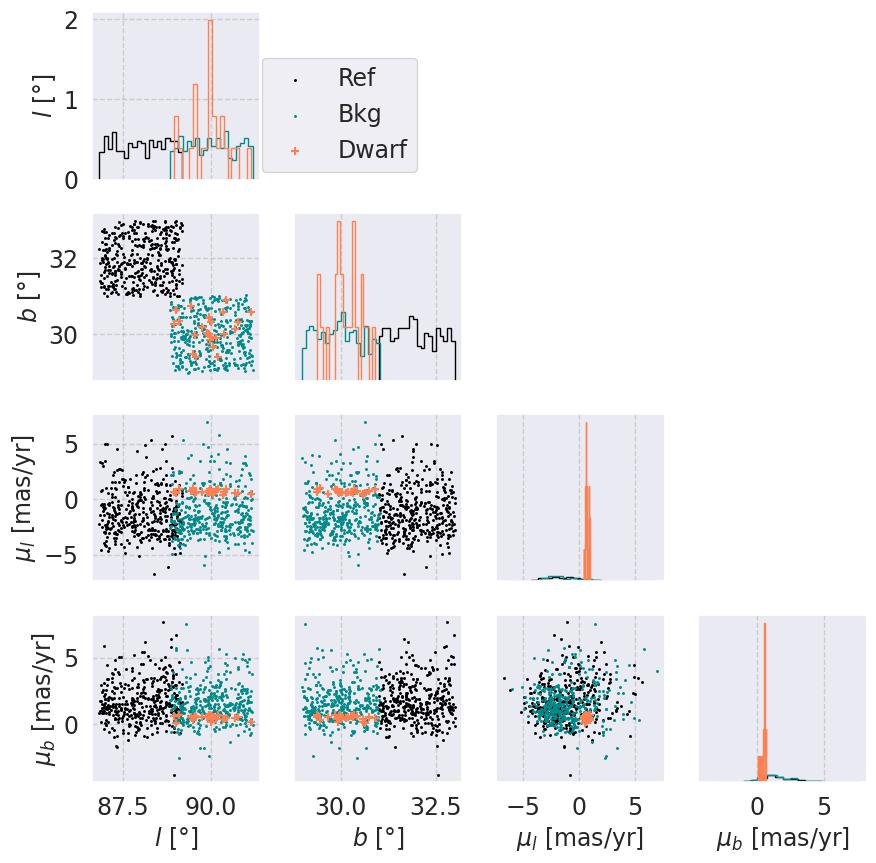

In [78]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

for i in range(4):
    for j in range(4):
        if i < j: ax[i,j].set_axis_off()
        if i > j:
            if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
            if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
            ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
        if i == j:
            if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = 20, color = color_ref)
            if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = 20, color = color_full)
            ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = 20, color = color_dw)
        if i == 3: 
            ax[i,j].set_xlabel(labels[j])
        if j == 0: 
            ax[i,j].set_ylabel(labels[i])
        else: 
            ax[i,j].set_yticks([])
    
#ax[0,0].set_xlim(lims[0])
#ax[3,1].set_xlim(lims[1])
#ax[3,2].set_xlim(lims[2])
#ax[3,3].set_xlim(lims[3])

ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))

In [6]:
def purity(upsilon, ind, up_th = 20):
    '''
    Function to compute the purity of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Purity defined as # dwarf stars (upsilon >= up_th) / # stars (upsilon >= up_th)
    '''
    return len(np.where(upsilon[ind] >= up_th)[0]) / len(np.where(upsilon >= up_th)[0])

def FPR(upsilon, ind, up_th = 20):
    '''
    Function to compute the false positive rate of the cluster found by EE.

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    False positive rate defined as # non-dwarf stars with upsilon >= up_th / # bkg stars
    '''
    ind_aux = np.arange(len(upsilon))
    ind_aux = np.delete(ind_aux, ind)
    return len(np.where(upsilon[ind_aux] >= up_th)[0]) / len(ind_aux)
    
def FNR(upsilon, ind, up_th = 20):
    '''
    Function to compute the dwarf stars missed by EE. (False Negative Rate)

    Parameters
    ----------

    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    FNR defined as # dwarf stars (upsilon < up_th) / # dwarf stars
    '''
    return len(np.where(upsilon[ind] < up_th)[0]) / len(ind)

def Delta(full, upsilon, ind, up_th = 20):
    '''
    Function to compute the distances (angular and peculiar velocity) between the center of the cluster found by EE
        and the dwarf galaxy.

    Parameters
    ----------

    full: (np.array) data of the analized stars.    
    upsilon: (np.array) upsilon values of all the analized stars.
    ind: (np.array int) indices of the stars that trully belong to the dwarf galaxy.
    up_th: (float) upsilon threshold. default = 20

    Returns
    -------

    Distances defined as 
        ang = np.sqrt( (l_{real} - <l>)^{2} + (b_{real} - <b>)^{2} )
        vpec = np.sqrt( (mul_{real} - <mul>)^{2} + (mub_{real} - <mub>)^{2} )
    '''
    l_real = np.mean(full[ind,0])
    b_real = np.mean(full[ind,1])
    mul_real = np.mean(full[ind,2])
    mub_real = np.mean(full[ind,3])

    ind_aux = np.where(upsilon >= up_th)[0]
    l_cluster = np.mean(full[ind_aux, 0])
    b_cluster = np.mean(full[ind_aux, 1])
    mul_cluster = np.mean(full[ind_aux, 2])
    mub_cluster = np.mean(full[ind_aux, 3])
    
    return np.sqrt( (l_real - l_cluster)**2 + (b_real - b_cluster)**2 ), \
           np.sqrt( (mul_real - mul_cluster)**2 + (mub_real - mub_cluster)**2 )

In [7]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']



def plotDwarf(ax, dw_data, full = None, ref = None, indices = None, nbins = 20):
    bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
            np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

    lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
            (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
            (np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3),
            (np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3)]

    if indices is not None: 
        cluster = full[indices,:] 
    else: 
        cluster = None
    
    for i in range(4):
        for j in range(4):
            if i < j: ax[i,j].set_axis_off()
            if i > j:
                #ax[i,j].set_xlim(lims[j])
                ax[i,j].set_ylim(lims[i])
                if cluster is not None: ax[i,j].scatter(cluster[:,j], cluster[:,i], edgecolor = color_cl, label = 'Cl', 
                                                        marker = 'o', s = 20, facecolor = 'none')
                if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
                if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
                ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
            if i == j:
                if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = bins[i], color = color_ref)
                if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = bins[i], color = color_full)
                ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = bins[i], color = color_dw)
                if cluster is not None: ax[i,j].hist(cluster[:,i], histtype = 'step', density = True, bins = bins[i], color = color_cl)
            if i == 3: 
                ax[i,j].set_xlabel(labels[j])
            #else:
             #   ax[i,j].set_xticks([])
            if j == 0: 
                ax[i,j].set_ylabel(labels[i])
            else: 
                ax[i,j].set_yticks([])
        
    ax[0,0].set_xlim(lims[0])
    ax[3,1].set_xlim(lims[1])
    ax[3,2].set_xlim(lims[2])
    ax[3,3].set_xlim(lims[3])
    
    ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))
    return ax

# Let's start the analysis

In [8]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

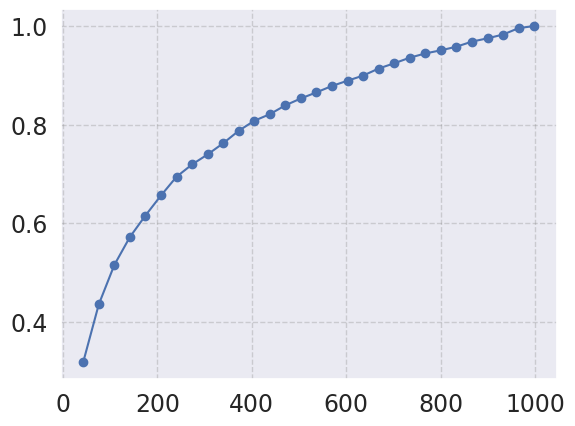

In [9]:
# Calcular el histograma
counts, bin_edges = np.histogram(data[:,12], bins=30, density=True)

# Calcular el histograma acumulado
cumulative_counts = np.cumsum(counts)  # Suma acumulativa

# Normalizar para que el acumulado llegue a 1
cumulative_counts /= cumulative_counts[-1]

# Graficar
plt.plot(bin_edges[1:], cumulative_counts, marker='o', linestyle='-')



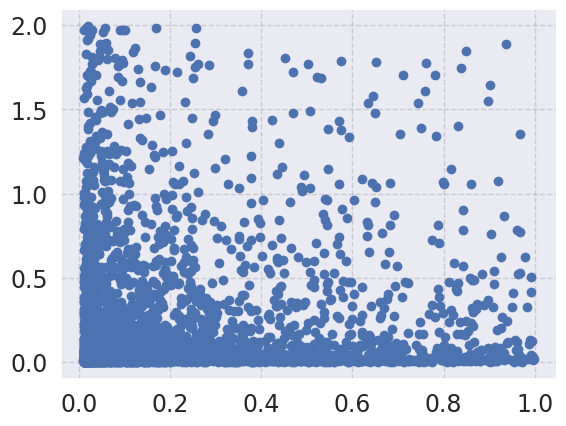

In [10]:
plt.scatter(data[:,13], data[:,14])

In [11]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences = 1000            # Number of Bernoulli sequences
K_M = 100                        # Length of each sequence
NUM_CORES = 100
NEIGHBOR_RANGE = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold


validation  = None         # Number of samples to use for validation
kstar_range = range(20, K_M) # Range of kstar values to consider

In [12]:
nside = 1
NPIX = hp.nside2npix(nside)
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat
len(np.where(np.abs(glat) > 20)[0])

8

In [13]:
glon

array([ 45., 135., 225., 315.,   0.,  90., 180., 270.,  45., 135., 225.,
       315.])

In [14]:
glon = glon[np.abs(glat) > 20]

In [15]:
glat = glat[np.abs(glat) > 20]

In [16]:
len(glon)

8

In [ ]:
start0 = time()
glon = [90]
glat = [30]

counter = 0
results = []

niter = 1
for iiter in range(niter):
    obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
    full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                                 eps_lat = 0, eps_lon = 0, row_limit = None, size = 2, reference = 'sim')
    bkg_data = full_aux[:-len(dw_data)]
    
    try:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=[10])
    except:
        result_dictionary_na = EagleEye.Soar(
                            ref, bkg_data, result_dict_in = {}, K_M =100, critical_quantiles = None,
                            num_cores=1, validation=None, partition_size=1, Upsilon_stars=None)
    for igal in tqdm(range(0, len(data))):
        start = time()
        if data[igal,12] < 400:
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
            print(len(obs))

            glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[iiter] # Just to center the dwarf galaxy
            glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[iiter]
            pmlon_dw = obs[:,5] / 1e3
            pmlat_dw = obs[:,6] / 1e3
            dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
            full = np.vstack((bkg_data, dw_data))
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )

                clusters = EagleEye.partitian_function(ref, full, result_dictionary, result_dictionary['Upsilon_star_plus'][0],
                           result_dictionary['Upsilon_star_minus'][0],K_M=K_M)
                IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, result_dictionary, full, ref, 
                                                     Upsilon_star = [list(result_dictionary['unique_elements_overdensities'].keys())[0]])
                overdensity_ind = IV_IE_dict['OVER_clusters'][0]['From_test']
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)
                upsilon = result_dictionary['stats']['Upsilon_i_plus']
                overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])                    
            
            result_dictionary['Ids'] = int(data[igal,0])
            result_dictionary['ang_sizes'] = data[igal,13]
            result_dictionary['vpec_sizes'] = data[igal,14]
            result_dictionary['nstars'] = len(obs)
            result_dictionary['bkg'] = (len(full) - len(dw_data))
            result_dictionary['glat'] = glat[iiter]
            result_dictionary['glon'] = glon[iiter]
            result_dictionary['overdensity_ind'] = overdensity_ind
            
            results.append(result_dictionary)
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))
stop0 = time()

Computing unique elements for quantile/s.
Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            


  0%|          | 0/3000 [00:00<?, ?it/s]

371
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 1/3000 [00:05<4:22:09,  5.24s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 371 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 371 stars at 1 positions
146
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 3/3000 [00:10<2:44:46,  3.30s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 146 stars at 1 positions
40
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 4/3000 [00:16<3:30:05,  4.21s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 40 stars at 1 positions
27
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 5/3000 [00:22<4:09:06,  4.99s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 27 stars at 1 positions
87
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 6/3000 [00:28<4:13:03,  5.07s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 87 stars at 1 positions
163
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 7/3000 [00:33<4:15:45,  5.13s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 163 stars at 1 positions
351
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 8/3000 [00:38<4:06:39,  4.95s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 351 stars at 1 positions
12
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 9/3000 [00:43<4:22:15,  5.26s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 12 stars at 1 positions
270
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 10/3000 [00:49<4:22:36,  5.27s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 270 stars at 1 positions
313
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 11/3000 [00:54<4:23:11,  5.28s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 313 stars at 1 positions
10
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 12/3000 [01:00<4:28:30,  5.39s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
13
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 13/3000 [01:06<4:43:45,  5.70s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 13 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 13 stars at 1 positions
47
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  0%|          | 15/3000 [01:12<3:40:05,  4.42s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 47 stars at 1 positions
11
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 16/3000 [01:18<3:59:44,  4.82s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 11 stars at 1 positions
211
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 17/3000 [01:23<4:06:08,  4.95s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 211 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 211 stars at 1 positions
215
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 19/3000 [01:29<3:16:57,  3.96s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 215 stars at 1 positions
312
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 20/3000 [01:34<3:32:36,  4.28s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 312 stars at 1 positions
132
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 21/3000 [01:39<3:44:26,  4.52s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 132 stars at 1 positions
378
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 22/3000 [01:45<3:55:16,  4.74s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 378 stars at 1 positions
159
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 23/3000 [01:50<4:03:20,  4.90s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 159 stars at 1 positions
55
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 24/3000 [01:57<4:28:40,  5.42s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 55 stars at 1 positions
36
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 25/3000 [02:03<4:46:52,  5.79s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 36 stars at 1 positions
88
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 26/3000 [02:09<4:39:02,  5.63s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 88 stars at 1 positions
115
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 27/3000 [02:14<4:34:03,  5.53s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 115 stars at 1 positions
46
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 28/3000 [02:21<4:50:54,  5.87s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 46 stars at 1 positions
34
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 29/3000 [02:27<5:02:55,  6.12s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 34 stars at 1 positions
23
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 30/3000 [02:34<5:11:08,  6.29s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 23 stars at 1 positions
40
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 31/3000 [02:41<5:16:52,  6.40s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 40 stars at 1 positions
329
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 32/3000 [02:46<5:01:01,  6.09s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 329 stars at 1 positions
38
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 33/3000 [02:53<5:09:49,  6.27s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 38 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 38 stars at 1 positions
364
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 35/3000 [02:58<3:48:03,  4.62s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 364 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 364 stars at 1 positions
198
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|          | 37/3000 [03:03<3:08:57,  3.83s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 198 stars at 1 positions
263
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 38/3000 [03:09<3:25:04,  4.15s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 263 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 263 stars at 1 positions
19
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 40/3000 [03:15<3:09:24,  3.84s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 19 stars at 1 positions
21
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 41/3000 [03:21<3:32:44,  4.31s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 21 stars at 1 positions
14
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 42/3000 [03:27<3:52:50,  4.72s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 14 stars at 1 positions
23
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 43/3000 [03:34<4:17:03,  5.22s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 23 stars at 1 positions
12
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  1%|▏         | 44/3000 [03:40<4:28:51,  5.46s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 12 stars at 1 positions
32
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 45/3000 [03:47<4:46:01,  5.81s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 32 stars at 1 positions
383
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 46/3000 [03:52<4:39:40,  5.68s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 383 stars at 1 positions
22
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 47/3000 [03:59<4:53:26,  5.96s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 22 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 22 stars at 1 positions
143
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 49/3000 [04:04<3:39:45,  4.47s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 143 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 143 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 143 stars at 1 positions
150
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 52/3000 [04:09<2:34:19,  3.14s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 150 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 150 stars at 1 positions
109
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 54/3000 [04:15<2:26:10,  2.98s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 109 stars at 1 positions
80
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 55/3000 [04:21<3:00:04,  3.67s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 80 stars at 1 positions
135
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 56/3000 [04:27<3:16:33,  4.01s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 135 stars at 1 positions
108
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 57/3000 [04:32<3:30:45,  4.30s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 108 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 108 stars at 1 positions
37
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 59/3000 [04:39<3:12:06,  3.92s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 37 stars at 1 positions
34
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 60/3000 [04:45<3:41:46,  4.53s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 34 stars at 1 positions
59
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 61/3000 [04:52<4:07:43,  5.06s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 59 stars at 1 positions
76
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 62/3000 [04:59<4:27:52,  5.47s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 76 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 76 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 76 stars at 1 positions
17
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 65/3000 [05:05<3:04:37,  3.77s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 17 stars at 1 positions
51
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 66/3000 [05:12<3:32:52,  4.35s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 51 stars at 1 positions
37
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 67/3000 [05:19<3:58:09,  4.87s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 37 stars at 1 positions
231
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 68/3000 [05:24<4:03:26,  4.98s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 231 stars at 1 positions
208
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 69/3000 [05:29<4:07:12,  5.06s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 208 stars at 1 positions
221
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 70/3000 [05:35<4:10:47,  5.14s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 221 stars at 1 positions
10
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 71/3000 [05:41<4:22:26,  5.38s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
19
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 72/3000 [05:47<4:31:42,  5.57s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 19 stars at 1 positions
14
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▏         | 73/3000 [05:54<4:47:42,  5.90s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 14 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 14 stars at 1 positions
108
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  2%|▎         | 75/3000 [05:59<3:36:20,  4.44s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 108 stars at 1 positions
80
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 76/3000 [06:06<4:03:16,  4.99s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 80 stars at 1 positions
108
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 77/3000 [06:11<4:07:22,  5.08s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 108 stars at 1 positions
22
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 78/3000 [06:18<4:28:31,  5.51s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 22 stars at 1 positions
17
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 79/3000 [06:24<4:44:38,  5.85s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 17 stars at 1 positions
149
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 80/3000 [06:30<4:37:14,  5.70s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 149 stars at 1 positions
298
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 81/3000 [06:35<4:32:16,  5.60s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 298 stars at 1 positions
147
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 82/3000 [06:40<4:27:50,  5.51s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 147 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 147 stars at 1 positions
43
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 84/3000 [06:47<3:40:24,  4.54s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 43 stars at 1 positions
30
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 85/3000 [06:54<4:06:31,  5.07s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 30 stars at 1 positions
55
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 86/3000 [07:01<4:27:37,  5.51s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 55 stars at 1 positions
110
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 87/3000 [07:06<4:24:38,  5.45s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 110 stars at 1 positions
155
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 88/3000 [07:11<4:23:01,  5.42s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 155 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 155 stars at 1 positions
22
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 90/3000 [07:18<3:38:26,  4.50s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 22 stars at 1 positions
345
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 91/3000 [07:23<3:48:41,  4.72s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 345 stars at 1 positions
10
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 92/3000 [07:29<4:04:44,  5.05s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
321
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 93/3000 [07:35<4:09:25,  5.15s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 321 stars at 1 positions
60
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 94/3000 [07:41<4:30:11,  5.58s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 60 stars at 1 positions
363
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 95/3000 [07:47<4:27:19,  5.52s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 363 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 363 stars at 1 positions
10
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 97/3000 [07:53<3:34:57,  4.44s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
55
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 99/3000 [08:00<3:14:34,  4.02s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 55 stars at 1 positions
90
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 100/3000 [08:05<3:27:50,  4.30s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 90 stars at 1 positions
10
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 101/3000 [08:11<3:47:02,  4.70s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 10 stars at 1 positions
69
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 102/3000 [08:18<4:12:13,  5.22s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 69 stars at 1 positions
334
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  3%|▎         | 103/3000 [08:23<4:14:22,  5.27s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 334 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 334 stars at 1 positions
26
Validation size is:  370
Validation size is:  370
Computing unique elements for quantile/s.
Validation size is:  370
Validation size is:  370


  4%|▎         | 105/3000 [08:30<3:33:58,  4.43s/it]

Upsilon_star_plus              N/A            
Upsilon_star_minus             N/A            
critical_quantiles             N/A            
Upsilon_i_plus_null            N/A            
Upsilon_i_minus_null           N/A            
It takes 0.00 hs to analyze a dwarf with 26 stars at 1 positions
It takes 0.00 hs to analyze a dwarf with 26 stars at 1 positions
138
Validation size is:  370


In [20]:
print('It takes {:.2f} hs to analyze {} dwarfs'.format((stop0-start0)/3600, counter))


It takes 0.00 hs to analyze 1 dwarfs


In [21]:
!ls ../data/*.json

../data/EEv7_bkg:2466_size_5_ref_2392.json


In [41]:
#Save in JSON file
#%with open(f"../data/EEv7_bkg:{bkg[0]}_size_{2}_ref_shuffle.json", "wb") as file:
#%    pickle.dump(results, file)

with open("../data/EEv7_bkg:2466_size_5_ref_2392.json", "rb") as file:
    results = pickle.load(file)

In [47]:
results[0]['stats']

{'Upsilon_i_minus': array([4.99e+00, 8.34e+00, 5.55e+00, ..., 5.55e-16, 5.55e-16, 5.55e-16]),
 'kstar_minus': array([97, 97, 99, ..., 53, 53, 53]),
 'Upsilon_i_plus': array([ 1.15,  0.23,  1.23, ..., 60.54, 60.54, 60.54]),
 'kstar_plus': array([21, 21, 26, ..., 99, 99, 99]),
 'Upsilon_i_Val_minus': array([ 2.2 ,  8.58, 11.19, ...,  0.06,  0.12,  0.83]),
 'kstar_Val_minus': array([85, 73, 31, ..., 75, 57, 20]),
 'Upsilon_i_Val_plus': array([1.30e+00, 7.57e-03, 8.15e-04, ..., 5.85e+00, 5.25e+00, 3.69e+00]),
 'kstar_Val_plus': array([31, 41, 51, ..., 24, 83, 46])}

In [46]:
ipos =0
df = calc_metrics(results[ipos], Upsilon_star_plus = list(results[ipos]['unique_elements_overdensities'].keys())[0])

KeyError: 'reference_samples'

In [ ]:
display(Markdown(df.to_markdown()))

In [23]:
Ids = np.zeros(len(results))
ang_sizes = np.zeros(len(results))
vpec_sizes = np.zeros(len(results))
nstars = np.zeros(len(results))
bkg = np.zeros(len(results))
glat = np.zeros(len(results))
glon = np.zeros(len(results))

for i in range(len(results)):
    Ids[i] = results[i]['Ids']
    ang_sizes[i] = results[i]['ang_sizes']
    vpec_sizes[i] = results[i]['vpec_sizes']
    nstars[i] = results[i]['nstars']
    bkg[i] = results[i]['bkg']
    glat[i] = results[i]['glat']
    glon[i] = results[i]['glon']

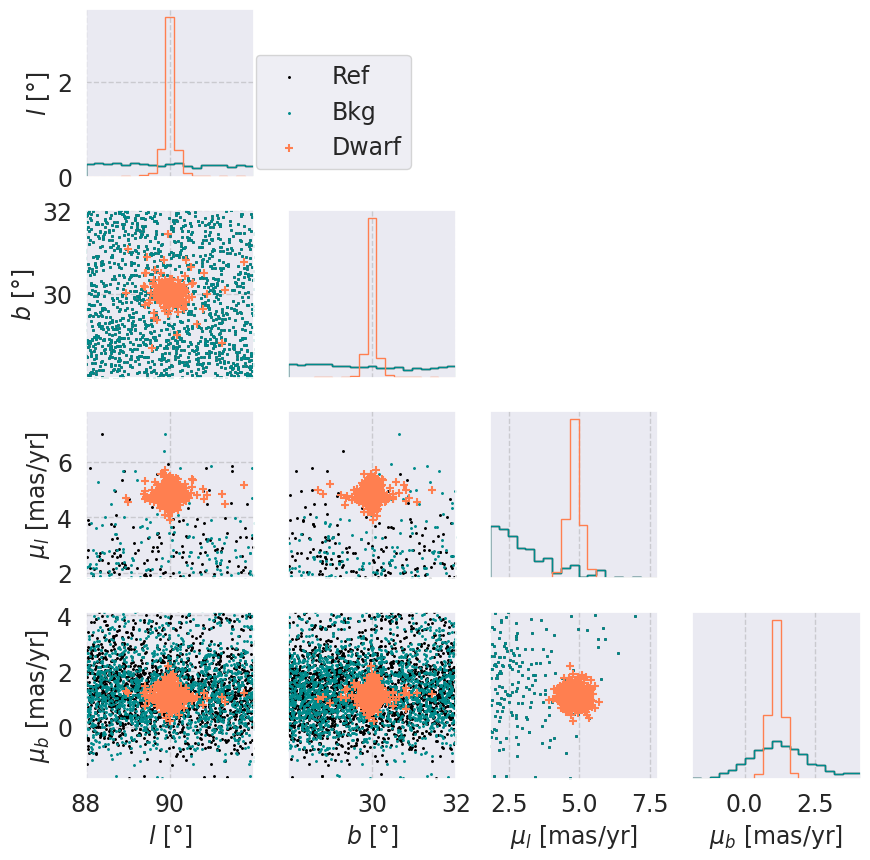

In [346]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

In [37]:
nups = 100

aux_pur = np.zeros((len(results), nups))
aux_FNR = np.zeros((len(results), nups))
aux_FPR = np.zeros((len(results), nups))

stats = np.zeros((len(results), 4))
for ipos in range(len(results)):
    result = results[ipos]['stats']
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    ind = np.arange(len(upsilon))[-results[ipos]['nstars']:]
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    for iups in range(nups):
        aux_pur[ipos, iups] = purity(upsilon, ind, up_th = up_range[iups])
        aux_FNR[ipos, iups] = FNR(upsilon, ind, up_th = up_range[iups])
        aux_FPR[ipos, iups] = FPR(upsilon, ind, up_th = up_range[iups])

    try:
        #%overdensity_ind = np.asarray(results[ipos]['unique_elements_overdensities'][list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[ipos]['Ids'])) + '.dat')
        glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
        glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[0]
        pmlon_dw = obs[:,5] / 1e3
        pmlat_dw = obs[:,6] / 1e3
        dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
        full = np.vstack((bkg_data, dw_data))
        
        clusters = EagleEye.partitian_function(ref, full, results[ipos], results[ipos]['Upsilon_star_plus'][0],
                                   results[ipos]['Upsilon_star_minus'][0],K_M=K_M)
        IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[ipos], full, ref, Upsilon_star = [list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        overdensity_ind = IV_IE_dict['OVER_clusters'][0]['From_test']
        
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    except:        
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    TP = len(np.where(overdensity_ind >= results[ipos]['bkg'])[0]) # True positives
    FP = len(np.where(overdensity_ind < results[ipos]['bkg'])[0]) # False positives
    TN = len(np.where(bkg_ind < results[ipos]['bkg'])[0]) # True negative
    FN = len(np.where(bkg_ind >= results[ipos]['bkg'])[0]) # False negative
    stats[ipos,0] = TP / (TP+FP) # purity/precision with equalization
    stats[ipos,1] = FP / results[ipos]['bkg'] # false positive rate
    stats[ipos,2] = TP / results[ipos]['nstars'] # true positive rate
    stats[ipos,3] = len(overdensity_ind) # number of stars in the overdensity

/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[

In [25]:
results = results_sim

NameError: name 'results_sim' is not defined

Using eq.


/u/m/mdelosri/miniconda3/envs/dwarf/lib/python3.8/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


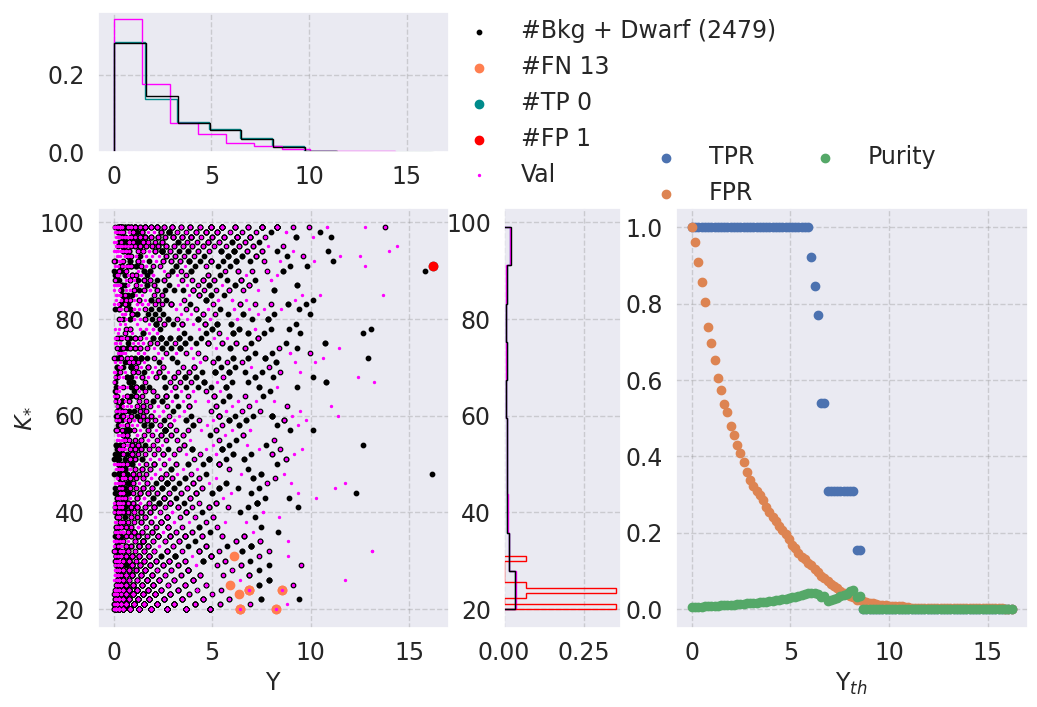

In [30]:
i = 12

upsilon = results[i]['stats']['Upsilon_i_plus']
kstar = results[i]['stats']['kstar_plus']
upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
kstar_na = result_dictionary_na['stats']['kstar_plus']

try:
    #%ind = np.asarray(results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]])
    obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[i]['Ids'])) + '.dat')
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[0]
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
    full = np.vstack((bkg_data, dw_data))
    
    clusters = EagleEye.partitian_function(ref, full, results[i], results[i]['Upsilon_star_plus'][0],
                                       results[i]['Upsilon_star_minus'][0],K_M=K_M)
    IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[i], full, ref, Upsilon_star = [list(results[i]['unique_elements_overdensities'].keys())[0]])
    ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
    
    print('Using eq.')
except:
    ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
    #ind = np.asarray(np.where(upsilon > 10)[0])
#ind = results[i]['overdensities'][10]
bkg_ind = np.delete(np.arange(len(upsilon)), ind)

try:
    upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
    kstar_val = results[i]['stats']['kstar_Val_plus']
    validation = len(upsilon_val)
except:
    validation = None
TP = len(np.where(ind >= results[i]['bkg'])[0]) # True positives
FP = len(np.where(ind < results[i]['bkg'])[0]) # False positives
TN = len(np.where(bkg_ind < results[i]['bkg'])[0]) # True negative
FN = len(np.where(bkg_ind >= results[i]['bkg'])[0]) # False negative

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, upsilon_na)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[3,1,3], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))

#plt.subplots_adjust()
ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
if validation is not None: ax[0,0].hist(upsilon_val, histtype = 'step', density = True, color = 'magenta')
#ax[0,0].hist(upsilons[i][-len(dw_data):], histtype = 'step', density = True, color = 'red')
ax[0,0].hist(upsilon_na, histtype = 'step', density = True, color = 'black')

ax[0,1].set_axis_off()

ax[1,0].scatter(upsilon, kstar, label = f'#Bkg + Dwarf ({len(upsilon)})', color = 'black', s = 10)
ax[1,0].scatter(upsilon[-results[i]['nstars']:], kstar[-results[i]['nstars']:], label = f'#FN {FN}', color = 'coral')
ax[1,0].scatter(upsilon[ind], kstar[ind], color = 'darkcyan', #marker = 'o',s=52, facecolors='none', 
                label = f"#TP {len(np.where(ind >= results[i]['bkg'])[0])}")
ax[1,0].scatter(upsilon[ind[np.where(ind < results[i]['bkg'])[0]]], kstar[ind[np.where(ind < results[i]['bkg'])[0]]], color = 'red', 
                label = f"#FP {len(np.where(ind < results[i]['bkg'])[0])}")
if validation is not None: ax[1,0].scatter(upsilon_val, kstar_val, label = 'Val', color = 'magenta', s = 2)
ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.99,1.5), frameon = False)
#ax[1,0].axvline(x = up_th)

ax[1,1].hist(kstar, histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
if validation is not None: ax[1,1].hist(kstar_val, histtype = 'step', density = True, color = 'magenta', orientation='horizontal')
ax[1,1].hist(kstar[-len(dw_data):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
ax[1,1].hist(kstar_na, histtype = 'step', density = True, color = 'black', orientation='horizontal')

ax[1,0].set_xlabel('$\\Upsilon$')
ax[1,0].set_ylabel('$K_{*}$')

#ax[1,0].text(0.45, 0.6,'Gal ID: {}'.format(Ids[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.5,'# Dwarf stars: {}'.format(nstars[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.4,'# Bkg stars: {} ({:.2f})'.format(bkg[i], nstars[i] / bkg[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.3,'(l,b) = ({:.0f}° ; {:.0f}°)'.format(glons[i], glats[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.2,'Pval = {:.1f}'.format(p_value), transform = ax[1,0].transAxes)

ax[0,2].set_axis_off()
ax[1,2].scatter(up_range, (1-aux_FNR[i,:]), label = 'TPR')
ax[1,2].scatter(up_range, aux_FPR[i,:], label = 'FPR')
ax[1,2].scatter(up_range, aux_pur[i,:], label = 'Purity')
ax[1,2].set_xlabel('$\\Upsilon_{th}$')
ax[1,2].legend(loc = 'upper right', bbox_to_anchor = (0.80,1.20), frameon = False, ncol = 2)

#plt.savefig(f'../graph/gal_{Ids[i]}_{bkg[i]}.pdf', bbox_inches='tight')


In [67]:
# get the distribution of Upsilon_i^+
over_clusters = IV_IE_dict.get("OVER_clusters", {})

# Suppose these are your arrays of Upsilon_i^+ for all test points and for the "OVER" subset
data_all = result_dictionary['stats']['Upsilon_i_plus']
all_overdensities = [
    idx 
    for cluster_data in over_clusters.values() 
    for idx in cluster_data.get('From_test', [])
]
all_eualized = [x for x in range(full.shape[0]) if x not in all_overdensities ]
NUMBER_CORES = 10
PARTITION_SIZE = 100

Upsilon_post_IE = EagleEye.pval_post_equalization(
    full, 
    ref, 
    all_eualized,
    K_M,
    NUMBER_CORES,
    PARTITION_SIZE
    )

In [68]:
Upsilon_post_IE

array([ 1.35,  0.29,  1.46, ..., 63.93, 63.93, 63.93])

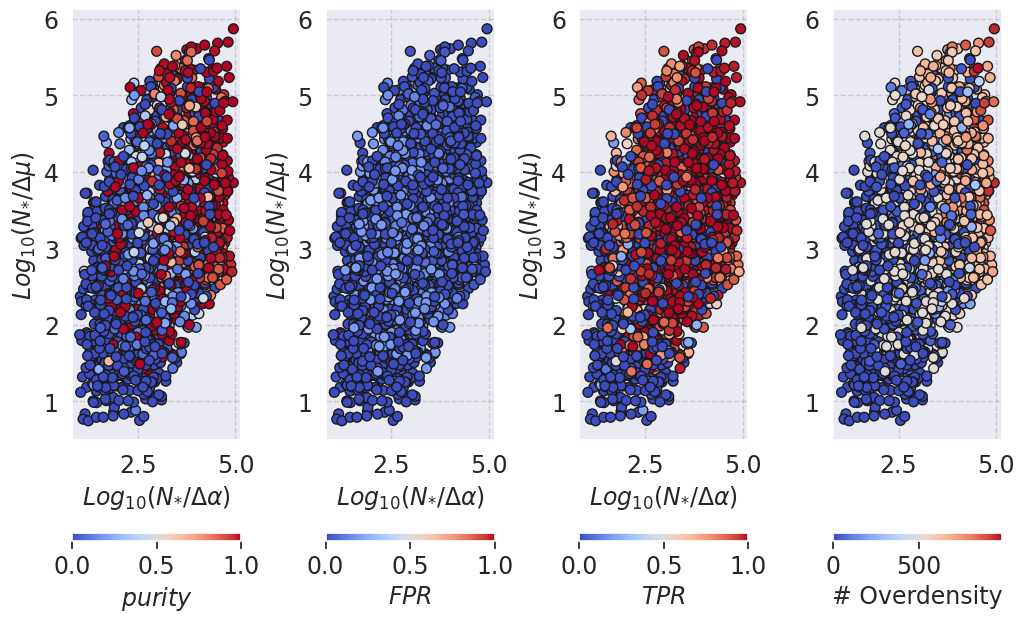

In [38]:
fig, ax = plt.subplots(1,4, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc1 = ax[1].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc2 = ax[2].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')

sc3 = ax[3].scatter(np.log10(np.asarray(nstars) / np.asarray(ang_sizes)), np.log10(np.asarray(nstars) / np.asarray(vpec_sizes)), c=stats[:,3], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = np.max(stats[:,3]))
plt.colorbar(sc3, label='# Overdensity', orientation = 'horizontal')
#plt.yscale('log')
#plt.xscale('log')

#plt.savefig(f'../graph/purity_{bkg[0]}_EEv7_ref:sim+eq+cl.pdf')

Text(0, 0.5, '$\\Delta \\mu$')

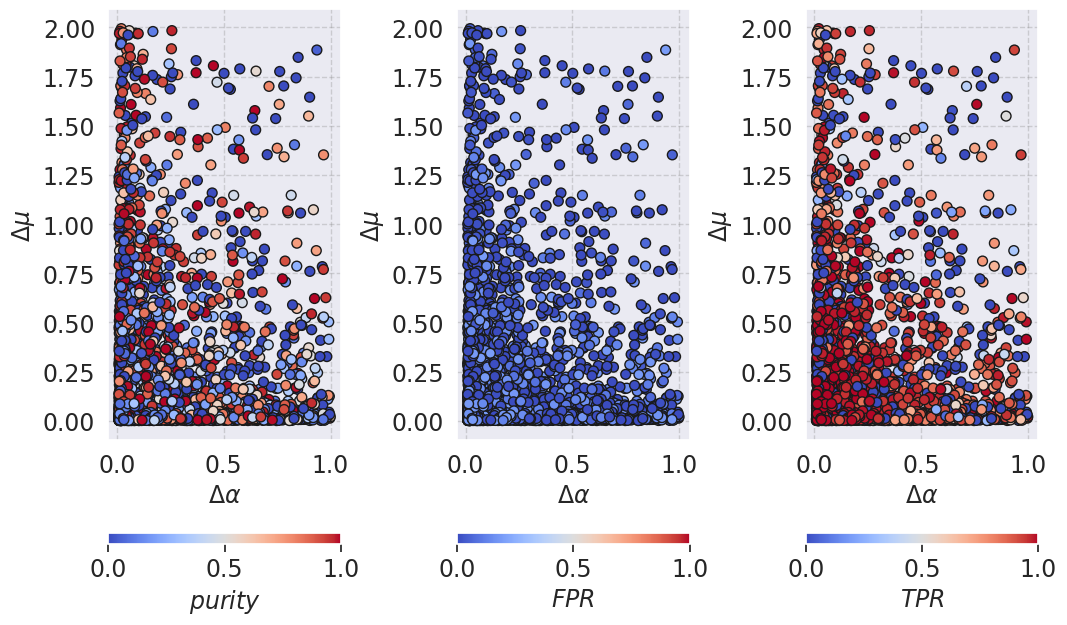

In [62]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
plt.subplots_adjust(wspace = 0.5)

sc0 = ax[0].scatter((ang_sizes), (vpec_sizes), c=stats[:,0], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc0, label='$purity$', orientation = 'horizontal')

ax[0].set_xlabel('$\Delta \\alpha$')
ax[0].set_ylabel('$\Delta \mu$')

sc1 = ax[1].scatter((ang_sizes), (vpec_sizes), c=stats[:,1], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc1, label='$FPR$', orientation = 'horizontal')

ax[1].set_xlabel('$\Delta \\alpha$')
ax[1].set_ylabel('$\Delta \mu$')

sc2 = ax[2].scatter((ang_sizes), (vpec_sizes), c=stats[:,2], cmap='coolwarm', edgecolor='k', s=50,
                   vmin = 0, vmax = 1)
plt.colorbar(sc2, label='$TPR$', orientation = 'horizontal')

ax[2].set_xlabel('$\Delta \\alpha$')
ax[2].set_ylabel('$\Delta \mu$')
#plt.savefig(f'../graph/purity2_{bkg[0]}_EEv7_ref:sim+eq+cl.pdf')


In [39]:
mean_pur, x_edges, y_edges, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,0], statistic='mean', bins=20)
mean_FPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,1], statistic='mean', bins=[x_edges,y_edges])
mean_TPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,2], statistic='mean', bins=[x_edges,y_edges])
mean_size, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,3], statistic='mean', bins=[x_edges,y_edges])

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

X_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Centros de los bins en X
Y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Centros de los bins en Y
X, Y = np.meshgrid(X_centers, Y_centers)

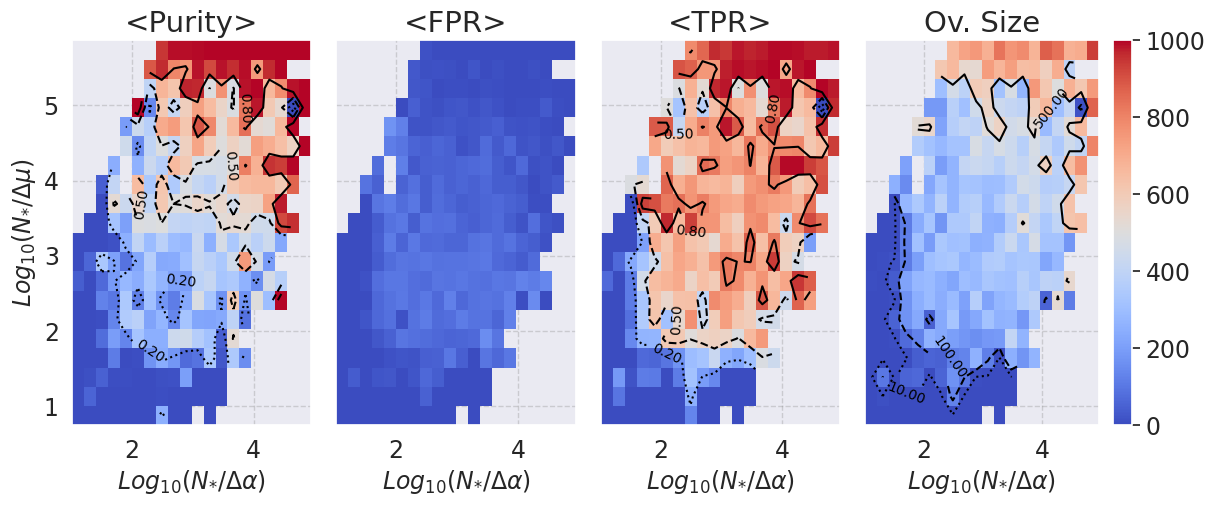

In [40]:
fig,ax = plt.subplots(1,4, figsize = (14,5), sharex = True, sharey = True, gridspec_kw = {'width_ratios':[0.82,0.82,0.82,1]})
plt.subplots_adjust(wspace = 0.1)

ax[0].pcolormesh(X_edges, Y_edges, mean_pur, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours0 = ax[0].contour(X, Y, mean_pur, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[0].clabel(contours0, inline=True, fontsize=10, fmt="%.2f")
ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
ax[0].set_title('<Purity>')

ax[1].pcolormesh(X_edges, Y_edges, mean_FPR, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours1 = ax[1].contour(X, Y, mean_FPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[1].clabel(contours1, inline=True, fontsize=10, fmt="%.2f")
ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_title('<FPR>')

cmap = ax[2].pcolormesh(X_edges, Y_edges, mean_TPR, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours2 = ax[2].contour(X, Y, mean_TPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[2].clabel(contours2, inline=True, fontsize=10, fmt="%.2f")
ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_title('<TPR>')

cmap = ax[3].pcolormesh(X_edges, Y_edges, mean_size, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1000)
contours3 = ax[3].contour(X, Y, mean_size, levels=[10, 100, 500], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[3].clabel(contours3, inline=True, fontsize=10, fmt="%.2f")
ax[3].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[3].set_title('Ov. Size')
plt.colorbar(cmap, ax=ax[3])

#plt.savefig(f'../graph/statsHeatmap_{bkg[0]}_ref:sim+eq+cl_EEv7.pdf')

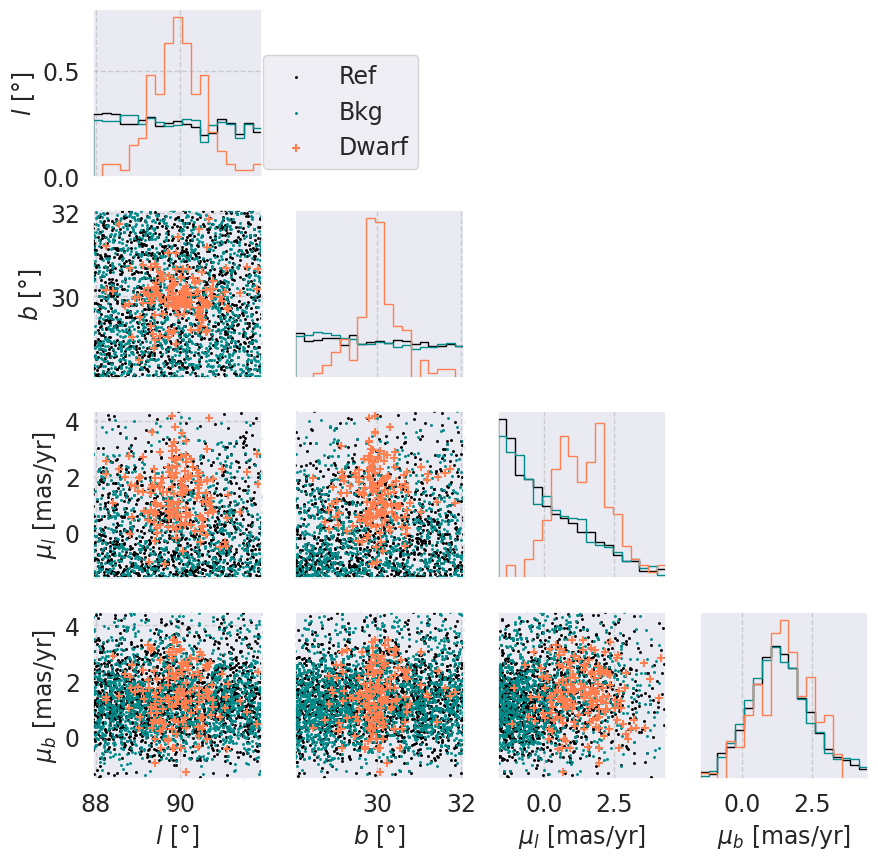

In [218]:
fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

ax = plotDwarf(ax, dw_data, bkg_data, ref)

#plt.savefig('../graph/gal_{}_4d.pdf'.format(Id), bbox_inches='tight')

In [168]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

for ipur in range(nups):
#ipur = 0
    pur = aux_pur[:,ipur]
    mapa = np.zeros(NPIX)  # Array 1D de ejemplo
    mapa[np.where(np.abs(glat) > 20)[0]] = pur
    
    # Graficar el mapa en coordenadas Mollweide
    hp.mollview(mapa, title="", unit="Purity", cmap="viridis")
    
    plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')
    
    plt.savefig('../graph/960622/gif/Moolview_{}_pur.png'.format(ipur), bbox_inches='tight')
    plt.close()

In [251]:
aux_pur.shape

(16, 100)

Text(0, 1.1, '$\\Upsilon = $210.19')

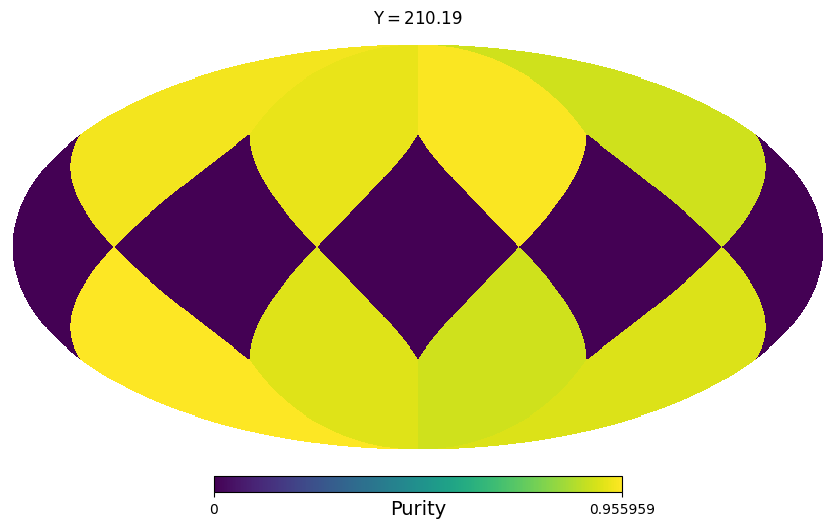

In [255]:
glat, glon = np.degrees(hp.pix2ang(nside, np.arange(NPIX)))
glat = 90 - glat

ipur = 60
pur = aux_pur[:8,ipur]
mapa = np.zeros(NPIX)  # Array 1D de ejemplo
mapa[np.where(np.abs(glat) > 20)[0]] = pur

# Graficar el mapa en coordenadas Mollweide
hp.mollview(mapa, title="", unit="Purity", cmap="viridis")

plt.text(0, 1.1, "$\\Upsilon = ${:.2f}".format(up_range[ipur]), fontsize=12, color='black', ha='center')

# Analysis varying references

In [79]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

In [80]:
# Generate 100,000 Bernoulli sequences to determine the critical Upsilon threshold
num_sequences     = 1000            # Number of Bernoulli sequences
K_M               = 100                        # Length of each sequence
NUM_CORES         = 100
NEIGHBOR_RANGE    = range(4, K_M)
critical_quantile = 0.9999        # Quantile to calculate critical Upsilon threshold


validation  = None         # Number of samples to use for validation
kstar_range = range(20, K_M) # Range of kstar values to consider

In [81]:
# Let's get the background
bgk_data = GetBkg(glon_center = 90, glat_center = 30, row_limit = None, size = 2)

In [264]:
# Let's get the references
references = []

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = 2) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = 0) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = -2) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = 2) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = 0) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = -2) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 0, delta_lat = -2) )

references.append( GetRef(glon_center = 90, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 0, delta_lat = 2) )



In [269]:
# Let's add a dwarf in a random reference

igal = np.random.randint(len(data))
obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
print(len(obs))

glon_dw  = (obs[:,2] * 180/np.pi - 90) + glon[0] + np.random.uniform(-1,1,1) # Just to center the dwarf galaxy
glat_dw  = (obs[:,3] * 180/np.pi - 30) + glat[0] - np.random.uniform(-1,1,1)
pmlon_dw = obs[:,5] / 1e3
pmlat_dw = obs[:,6] / 1e3
dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

iref = np.random.randint(len(references))
print(iref, len(references[iref]))

# Remove dwarf stars outside patch
ind = np.where( (dw_data[:,0] >= np.min(references[iref][:,0])) &
                (dw_data[:,0] <= np.max(references[iref][:,0])) &
                (dw_data[:,1] >= np.min(references[iref][:,1])) &
                (dw_data[:,1] <= np.max(references[iref][:,1])) &
                (dw_data[:,2] >= np.min(references[iref][:,2])) &
                (dw_data[:,2] <= np.max(references[iref][:,2])) &
                (dw_data[:,3] >= np.min(references[iref][:,3])) &
                (dw_data[:,3] <= np.max(references[iref][:,3])) 
              )[0]
dw_data = dw_data[ind]
references[iref] = np.vstack((references[iref], dw_data))
print(len(references[iref]))


181
1 735
868


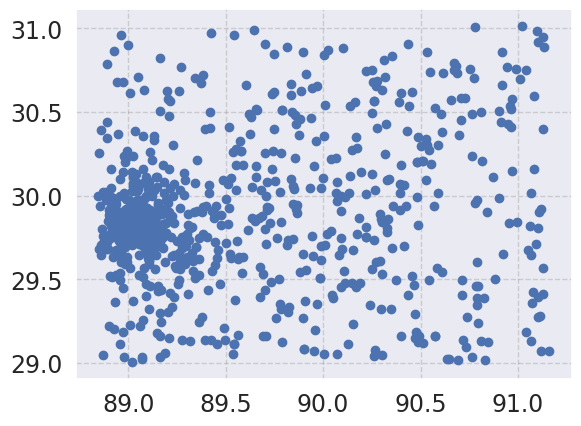

In [270]:
plt.scatter(references[iref][:,0], references[iref][:,1])

In [228]:
len(np.where( (data[:,12]<30) & (data[:,13] < 0.2))[0])

448

In [233]:
len(data)

3000

In [370]:
counter

80

In [ ]:
start0 = time()

glon = [90]
glat = [30]

counter = 0
results = []

for igal in tqdm(range(10, 100)):
    if (data[igal,12]<3000) & (data[igal,13] < 20.2):
        start = time()

        # Let's imprint the dwarf into the bkg_data
        
        obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
        print(len(obs))

        glon_dw  = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
        glat_dw  = (obs[:,3] * 180/np.pi - 30) + glat[0]
        pmlon_dw = obs[:,5] / 1e3
        pmlat_dw = obs[:,6] / 1e3
        dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
        
        # Remove dwarf stars outside patch
        ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                        (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                        (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                        (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                        (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                        (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                        (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                        (dw_data[:,3] <= np.max(bkg_data[:,3])) 
                      )[0]
        dw_data = dw_data[ind]

        full = np.vstack((bkg_data, dw_data))
        # ---------------------------------------------------------------------
        
        # Begin calls to EagleEye (version 7)
        for ref in references:
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
    
                clusters = EagleEye.partitian_function(ref, full, result_dictionary, result_dictionary['Upsilon_star_plus'][0],
                           result_dictionary['Upsilon_star_minus'][0],K_M=K_M)
                IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, result_dictionary, full, ref, 
                                                     Upsilon_star = [list(result_dictionary['unique_elements_overdensities'].keys())[0]])
                overdensity_ind = IV_IE_dict['OVER_clusters'][0]['From_test']
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)
                upsilon = result_dictionary['stats']['Upsilon_i_plus']
                overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])                    
            
            result_dictionary['Ids'] = int(data[igal,0])
            result_dictionary['ang_sizes'] = data[igal,13] # [°]
            result_dictionary['vpec_sizes'] = data[igal,14] # [mas/yr]
            result_dictionary['nstars'] = len(obs)
            result_dictionary['bkg'] = (len(full) - len(dw_data))
            result_dictionary['glat'] = glat[iiter]
            result_dictionary['glon'] = glon[iiter]
            result_dictionary['overdensity_ind'] = overdensity_ind
            
            results.append(result_dictionary)
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))
stop0 = time()

  0%|          | 0/90 [00:00<?, ?it/s]

313
Validation size is:  308
Validation size is:  308


In [272]:
print('It takes {:.2f} hs to analyze {} dwarfs'.format((stop0-start0)/3600, counter))


It takes 0.44 hs to analyze 80 dwarfs


In [273]:
Ids = np.zeros(len(results))
ang_sizes = np.zeros(len(results))
vpec_sizes = np.zeros(len(results))
nstars = np.zeros(len(results))
bkg = np.zeros(len(results))
glat = np.zeros(len(results))
glon = np.zeros(len(results))

for i in range(len(results)):
    Ids[i] = results[i]['Ids']
    ang_sizes[i] = results[i]['ang_sizes']
    vpec_sizes[i] = results[i]['vpec_sizes']
    nstars[i] = results[i]['nstars']
    bkg[i] = results[i]['bkg']
    glat[i] = results[i]['glat']
    glon[i] = results[i]['glon']

In [276]:
nups = 100

aux_pur = np.zeros((len(results), nups))
aux_FNR = np.zeros((len(results), nups))
aux_FPR = np.zeros((len(results), nups))

stats = np.zeros((len(results), 4))
for ipos in range(len(results)):
    result = results[ipos]['stats']
    ref = references[ipos%8]
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    upsilon = result['Upsilon_i_plus'] #upsilons[ipos]
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[ipos]['Ids'])) + '.dat')
    #print(len(obs))
    
    glon_dw  = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
    glat_dw  = (obs[:,3] * 180/np.pi - 30) + glat[0]
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
    
    # Remove dwarf stars outside patch
    ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                    (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                    (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                    (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                    (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                    (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                    (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                    (dw_data[:,3] <= np.max(bkg_data[:,3])) 
                  )[0]
    dw_data = dw_data[ind]
    
    ind = np.arange(len(upsilon))[-results[ipos]['nstars']:]
    for iups in range(nups):
        aux_pur[ipos, iups] = purity(upsilon, ind, up_th = up_range[iups])
        aux_FNR[ipos, iups] = FNR(upsilon, ind, up_th = up_range[iups])
        aux_FPR[ipos, iups] = FPR(upsilon, ind, up_th = up_range[iups])

    try:
        #%overdensity_ind = np.asarray(results[ipos]['unique_elements_overdensities'][list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        clusters = EagleEye.partitian_function(ref, full, results[ipos], results[ipos]['Upsilon_star_plus'][0],
                                   results[ipos]['Upsilon_star_minus'][0],K_M=K_M)
        IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[ipos], full, ref, Upsilon_star = [list(results[ipos]['unique_elements_overdensities'].keys())[0]])
        overdensity_ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
        
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    except:        
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    TP = len(np.where(overdensity_ind >= results[ipos]['bkg'])[0]) # True positives
    FP = len(np.where(overdensity_ind < results[ipos]['bkg'])[0]) # False positives
    TN = len(np.where(bkg_ind < results[ipos]['bkg'])[0]) # True negative
    FN = len(np.where(bkg_ind >= results[ipos]['bkg'])[0]) # False negative
    stats[ipos,0] = TP / (TP+FP) # purity/precision with equalization
    stats[ipos,1] = FP / results[ipos]['bkg'] # false positive rate
    stats[ipos,2] = TP / results[ipos]['nstars'] # true positive rate
    stats[ipos,3] = len(overdensity_ind) # number of stars in the overdensity

In [277]:
mean_pur, x_edges, y_edges, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,0], statistic='mean', bins=20)
mean_FPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,1], statistic='mean', bins=[x_edges,y_edges])
mean_TPR, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,2], statistic='mean', bins=[x_edges,y_edges])
mean_size, _, _, _ = binned_statistic_2d(np.log10(nstars / ang_sizes), np.log10(nstars / vpec_sizes), stats[:,3], statistic='mean', bins=[x_edges,y_edges])

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

X_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Centros de los bins en X
Y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Centros de los bins en Y
X, Y = np.meshgrid(X_centers, Y_centers)

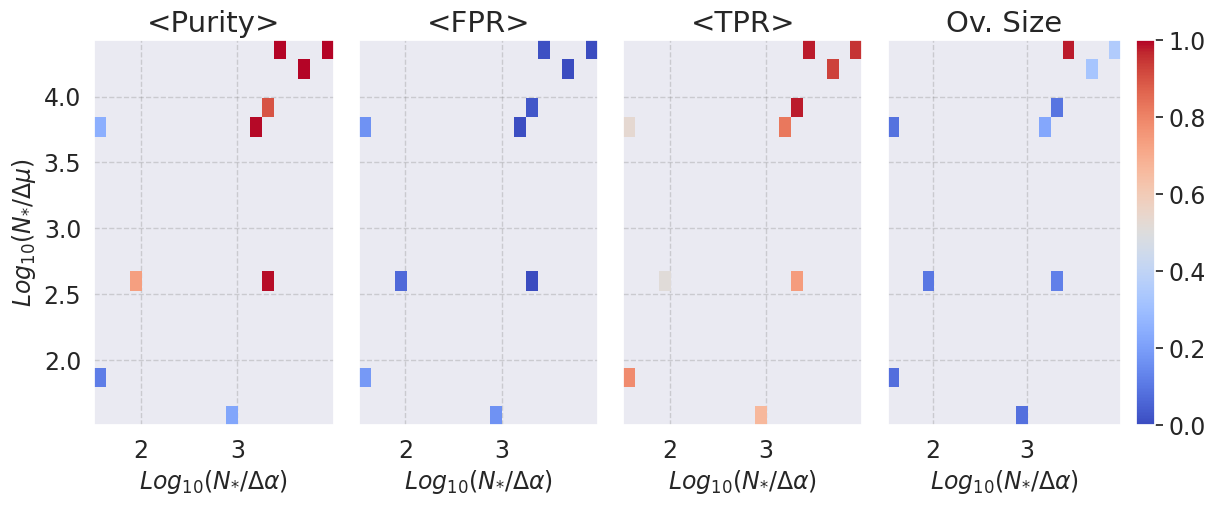

In [278]:
fig,ax = plt.subplots(1,4, figsize = (14,5), sharex = True, sharey = True, gridspec_kw = {'width_ratios':[0.82,0.82,0.82,1]})
plt.subplots_adjust(wspace = 0.1)

ax[0].pcolormesh(X_edges, Y_edges, mean_pur, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours0 = ax[0].contour(X, Y, mean_pur, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[0].clabel(contours0, inline=True, fontsize=10, fmt="%.2f")
ax[0].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[0].set_ylabel('$Log_{10}(N_{*}/\Delta \mu)$')
ax[0].set_title('<Purity>')

ax[1].pcolormesh(X_edges, Y_edges, mean_FPR, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours1 = ax[1].contour(X, Y, mean_FPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[1].clabel(contours1, inline=True, fontsize=10, fmt="%.2f")
ax[1].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[1].set_title('<FPR>')

cmap = ax[2].pcolormesh(X_edges, Y_edges, mean_TPR, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1)
contours2 = ax[2].contour(X, Y, mean_TPR, levels=[0.2, 0.5, 0.8], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[2].clabel(contours2, inline=True, fontsize=10, fmt="%.2f")
ax[2].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[2].set_title('<TPR>')

ax[3].pcolormesh(X_edges, Y_edges, mean_size, cmap="coolwarm", shading='auto', vmin = 0, vmax = 1000)
contours3 = ax[3].contour(X, Y, mean_size, levels=[10, 100, 500], colors='black', linestyles = [':','--','solid'], origin='upper')
ax[3].clabel(contours3, inline=True, fontsize=10, fmt="%.2f")
ax[3].set_xlabel('$Log_{10}(N_{*}/\Delta \\alpha)$')
ax[3].set_title('Ov. Size')
plt.colorbar(cmap, ax=ax[3])

#plt.savefig(f'../graph/statsHeatmap_{bkg[0]}_ref:sim+eq+cl_EEv7.pdf')

146
Using threshold
Using threshold
Using eq.
Using threshold
Using threshold
Using eq.
Using eq.
Using threshold


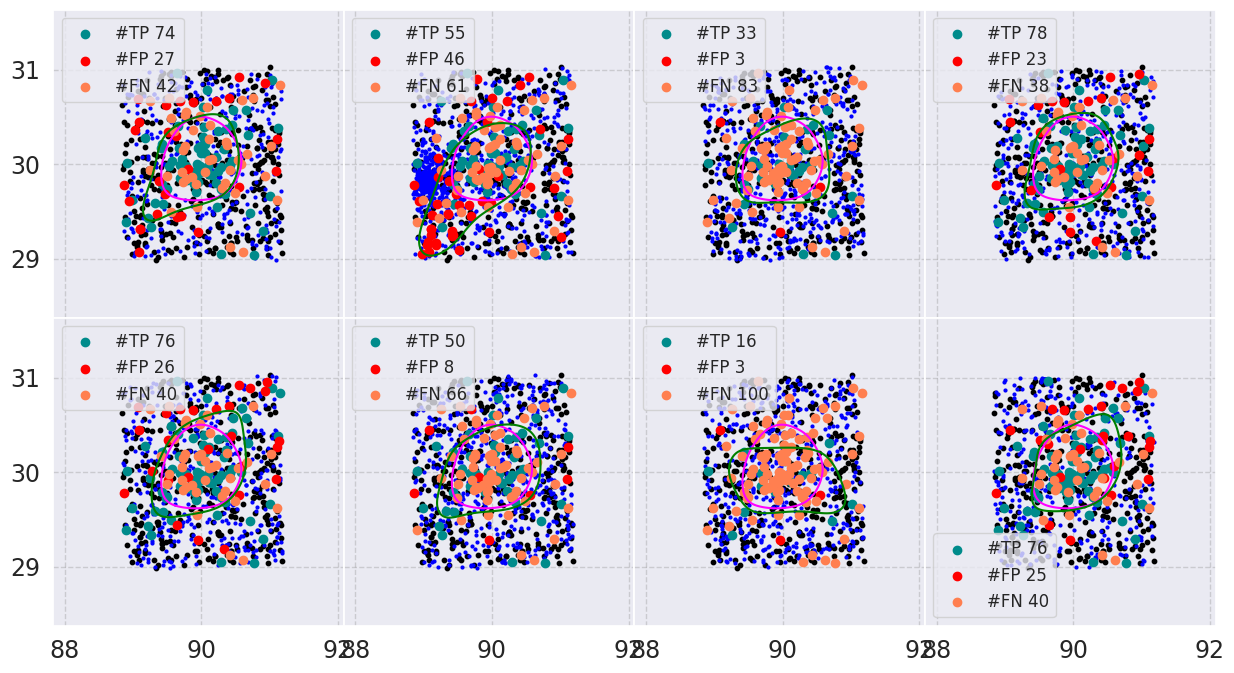

In [279]:
igal = 3

obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[(igal-1)*8]['Ids'])) + '.dat')
print(len(obs))

glon_dw  = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
glat_dw  = (obs[:,3] * 180/np.pi - 30) + glat[0]
pmlon_dw = obs[:,5] / 1e3
pmlat_dw = obs[:,6] / 1e3
dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

# Remove dwarf stars outside patch
ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                (dw_data[:,3] <= np.max(bkg_data[:,3])) 
              )[0]
dw_data = dw_data[ind]

full = np.vstack((bkg_data, dw_data))

fig,ax = plt.subplots(2,4, gridspec_kw = {'wspace':0, 'hspace':0},
                     sharex = True, sharey = True,
                      figsize = (15,8))

contador = 0
for i in range((igal-1)*8, igal*8):
    ref = references[i%8]
    upsilon = results[i]['stats']['Upsilon_i_plus']
    kstar = results[i]['stats']['kstar_plus']
    upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
    kstar_na = result_dictionary_na['stats']['kstar_plus']
    try:
        #%ind = np.asarray(results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]])
        clusters = EagleEye.partitian_function(ref, full, results[i], results[i]['Upsilon_star_plus'][0],
                                           results[i]['Upsilon_star_minus'][0],K_M=K_M)
        IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[i], full, ref, Upsilon_star = [list(results[i]['unique_elements_overdensities'].keys())[0]])
        overdensity_ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
        
        print('Using eq.')
    except:
        print('Using threshold')
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        #overdensity_ind = np.asarray(np.where(upsilon > 10)[0])
    #ind = results[i]['overdensities'][10]
    bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    
    try:
        upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
        kstar_val = results[i]['stats']['kstar_Val_plus']
        validation = len(upsilon_val)
    except:
        validation = None
        
    TP = len(np.where(overdensity_ind >= results[i]['bkg'])[0]) # True positives
    FP = len(np.where(overdensity_ind < results[i]['bkg'])[0]) # False positives
    TN = len(np.where(bkg_ind < results[i]['bkg'])[0]) # True negative
    FN = len(np.where(bkg_ind >= results[i]['bkg'])[0]) # False negative
    
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    
    statistic, p_value = ks_2samp(upsilon, upsilon_na) 
    
    ax[int(contador/4),contador%4].scatter(full[:,0], full[:,1], color = 'black', s = 10)
    ax[int(contador/4),contador%4].scatter(ref[:,0], ref[:,1], color = 'blue', s = 4)
    #ax[int(i/4),i%4].scatter(full[:,0], full[:,1], label = 'Bkg', color = 'black')

    TP_ind = overdensity_ind[np.where(overdensity_ind >= results[i]['bkg'])[0]]
    ax[int(contador/4),contador%4].scatter(full[TP_ind,0], 
                             full[TP_ind,1], label = f"#TP {len(TP_ind)}", color = 'darkcyan')
    
    FP_ind = overdensity_ind[np.where(overdensity_ind < results[i]['bkg'])[0]]
    ax[int(contador/4),contador%4].scatter(full[FP_ind,0], 
                             full[FP_ind,1], label = f"#FP {len(FP_ind)}", color = 'red')
    
    FN_ind = bkg_ind[np.where(bkg_ind >= results[i]['bkg'])[0]]
    ax[int(contador/4),contador%4].scatter(full[FN_ind, 0], 
                             full[FN_ind,1], label = f"#FN {len(FN_ind)}", color = 'coral')
    
    ax[int(contador/4),contador%4].legend(fontsize=12)
    #ax[int(contador/4),contador%4].scatter(dw_data[:,0], dw_data[:,1], label = 'Dw', color = 'magenta', marker = '+')
    sns.kdeplot(x=dw_data[:, 0], y=dw_data[:, 1], color = 'magenta', fill=False, ax = ax[int(contador/4),contador%4], levels = [0.5])
    
    sns.kdeplot(x=full[overdensity_ind, 0], y=full[overdensity_ind, 1], color = 'green', fill=False, ax = ax[int(contador/4),contador%4], levels = [0.5])
    
    ax[int(contador/4),contador%4].set_xlabel('')
    ax[int(contador/4),contador%4].set_ylabel('')
        
    contador += 1

#plt.savefig(f'../graph/gal_{Ids[i]}_{bkg[i]}.pdf', bbox_inches='tight')


40
Using threshold
Using threshold
Using threshold
Using threshold
Using threshold
Using threshold
Using threshold
Using threshold


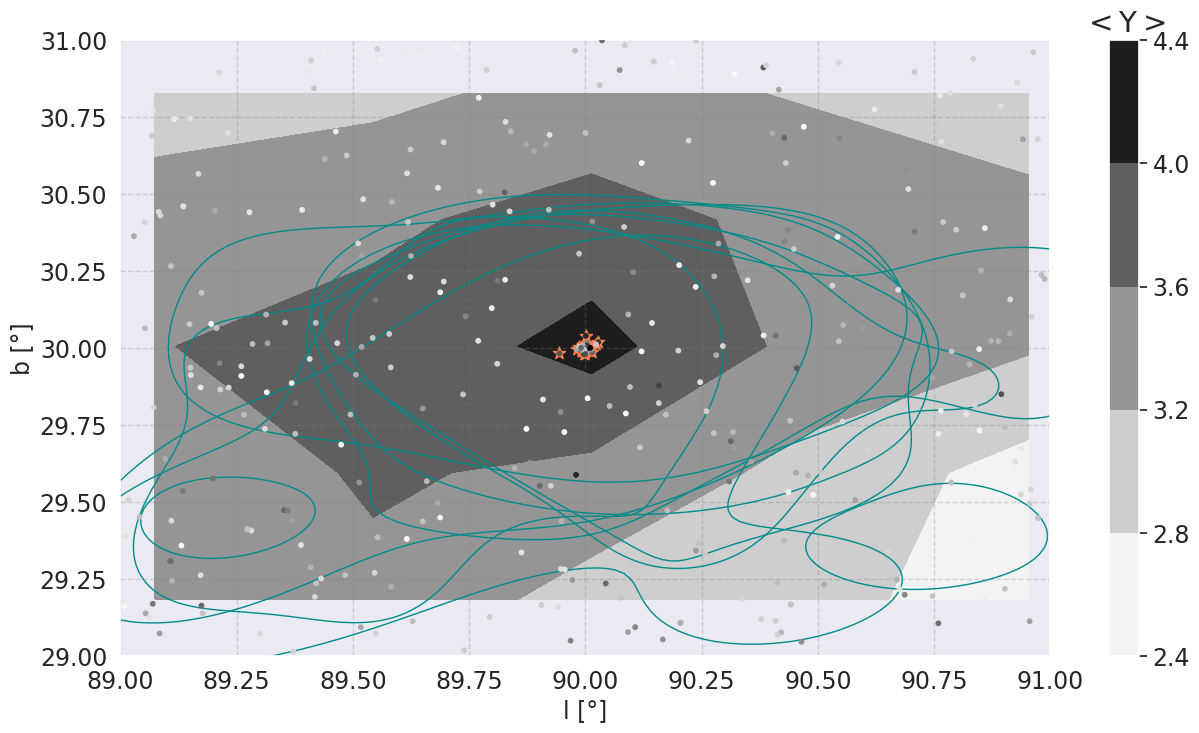

In [368]:
igal = 4

obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[(igal-1)*8]['Ids'])) + '.dat')
print(len(obs))

glon_dw  = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
glat_dw  = (obs[:,3] * 180/np.pi - 30) + glat[0]
pmlon_dw = obs[:,5] / 1e3
pmlat_dw = obs[:,6] / 1e3
dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

# Remove dwarf stars outside patch
ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                (dw_data[:,3] <= np.max(bkg_data[:,3])) 
              )[0]
dw_data = dw_data[ind]

full = np.vstack((bkg_data, dw_data))

fig,ax = plt.subplots(1,1,figsize = (15,8))

upsilon_list = []
for i in range((igal-1)*8, igal*8):
    ref = references[i%8]
    upsilon = results[i]['stats']['Upsilon_i_plus']
    upsilon_list.append(upsilon)
    kstar = results[i]['stats']['kstar_plus']
    upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
    kstar_na = result_dictionary_na['stats']['kstar_plus']
    try:
        #%ind = np.asarray(results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]])
        clusters = EagleEye.partitian_function(ref, full, results[i], results[i]['Upsilon_star_plus'][0],
                                           results[i]['Upsilon_star_minus'][0],K_M=K_M)
        IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[i], full, ref, Upsilon_star = [list(results[i]['unique_elements_overdensities'].keys())[0]])
        overdensity_ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
        
        print('Using eq.')
    except:
        print('Using threshold')
        overdensity_ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
        #overdensity_ind = np.asarray(np.where(upsilon > 10)[0])
    #ind = results[i]['overdensities'][10]
    bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    
    try:
        upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
        kstar_val = results[i]['stats']['kstar_Val_plus']
        validation = len(upsilon_val)
    except:
        validation = None
        
    TP = len(np.where(overdensity_ind >= results[i]['bkg'])[0]) # True positives
    FP = len(np.where(overdensity_ind < results[i]['bkg'])[0]) # False positives
    TN = len(np.where(bkg_ind < results[i]['bkg'])[0]) # True negative
    FN = len(np.where(bkg_ind >= results[i]['bkg'])[0]) # False negative
    
    up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)
    
    statistic, p_value = ks_2samp(upsilon, upsilon_na)  
    
    #sns.kdeplot(x=full[overdensity_ind, 0], y=full[overdensity_ind, 1], color = 'darkcyan', fill=True, ax = ax, levels = [0.5,1], alpha = 0.2)
    sns.kdeplot(x=full[overdensity_ind, 0], y=full[overdensity_ind, 1], color = 'darkcyan', fill=False, ax = ax, levels = [0.5], linewidths = [1])


sns.kdeplot(x=dw_data[:, 0], y=dw_data[:, 1], color = 'coral', fill=False, ax = ax, levels = [0.5], linewidths = [4])
ax.scatter(dw_data[:,0], dw_data[:,1], color = 'coral', s = 85, marker = '*')

mean_upsilon, x_edges, y_edges, _ = binned_statistic_2d(full[:,0], full[:,1], np.mean(np.asarray(upsilon_list),axis = 0), statistic='mean', bins=5)
mean_upsilon_smooth = gaussian_filter(mean_upsilon, sigma=0.5)

X_edges, Y_edges = np.meshgrid(x_edges, y_edges)

X_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Centros de los bins en X
Y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Centros de los bins en Y
X, Y = np.meshgrid(X_centers, Y_centers)
ax0 = ax.contourf(X_centers,Y_centers,mean_upsilon_smooth,levels = 3, cmap = 'Greys', zorder = 0)

cbar = plt.colorbar(ax0)
cbar.ax.set_title(r'$<\Upsilon>$')
ax.scatter(full[:,0], full[:,1], c = np.mean(np.asarray(upsilon_list),axis = 0), s = 10, cmap = 'Greys', zorder = 9)

ax.set_xlabel('l [°]')
ax.set_ylabel('b [°]')

ax.set_xlim(89,91)
ax.set_ylim(29,31)
plt.savefig(f"../graph/gal_{results[(igal-1)*8]['Ids']}_{len(bkg_ind)}_8ref.pdf", bbox_inches='tight')


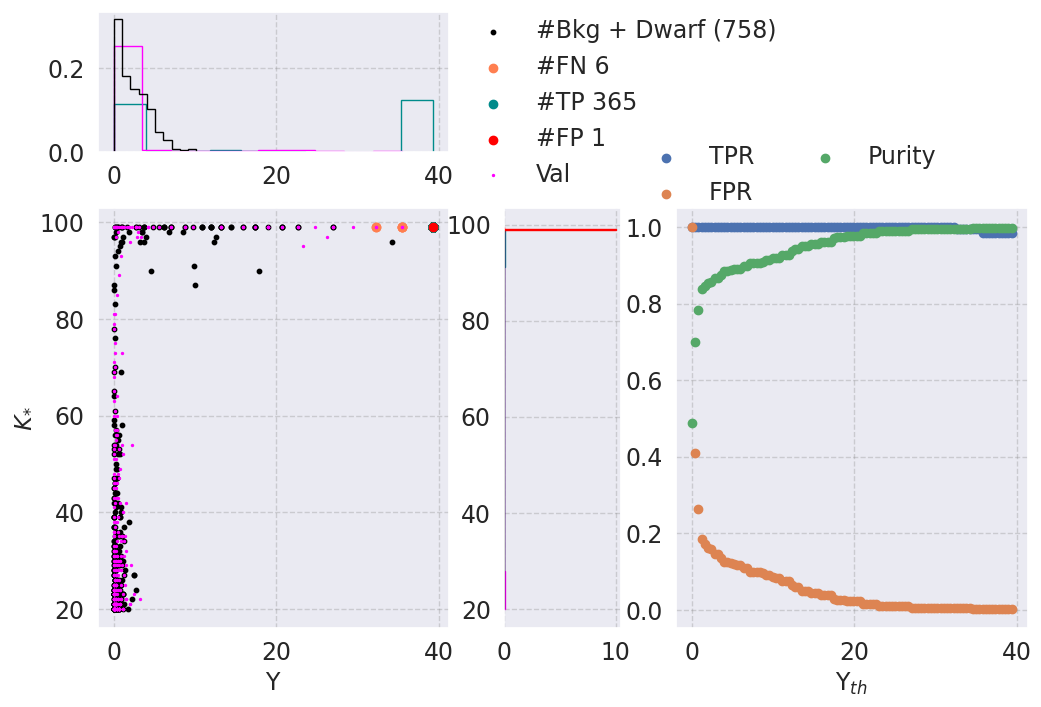

In [281]:
i = 3

upsilon = results[i]['stats']['Upsilon_i_plus']
kstar = results[i]['stats']['kstar_plus']
upsilon_na = result_dictionary_na['stats']['Upsilon_i_plus']
kstar_na = result_dictionary_na['stats']['kstar_plus']

try:
    #%ind = np.asarray(results[i]['unique_elements_overdensities'][list(results[i]['unique_elements_overdensities'].keys())[0]])
    obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(results[i]['Ids'])) + '.dat')
    glon_dw = (obs[:,2] * 180/np.pi - 90) + glon[0] # Just to center the dwarf galaxy
    glat_dw = (obs[:,3] * 180/np.pi - 30) + glat[0]
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
    full = np.vstack((bkg_data, dw_data))
    
    clusters = EagleEye.partitian_function(ref, full, results[i], results[i]['Upsilon_star_plus'][0],
                                       results[i]['Upsilon_star_minus'][0],K_M=K_M)
    IV_IE_dict = EagleEye.IV_IE_get_dict(clusters, results[i], full, ref, Upsilon_star = [list(results[i]['unique_elements_overdensities'].keys())[0]])
    ind = np.asarray(IV_IE_dict['OVER_clusters'][0]['From_test'])
    
    print('Using eq.')
except:
    ind = np.asarray(np.where(upsilon >= np.quantile(upsilon, 0.8))[0])
    #ind = np.asarray(np.where(upsilon > 10)[0])
#ind = results[i]['overdensities'][10]
bkg_ind = np.delete(np.arange(len(upsilon)), ind)

try:
    upsilon_val = results[i]['stats']['Upsilon_i_Val_plus']
    kstar_val = results[i]['stats']['kstar_Val_plus']
    validation = len(upsilon_val)
except:
    validation = None
TP = len(np.where(ind >= results[i]['bkg'])[0]) # True positives
FP = len(np.where(ind < results[i]['bkg'])[0]) # False positives
TN = len(np.where(bkg_ind < results[i]['bkg'])[0]) # True negative
FN = len(np.where(bkg_ind >= results[i]['bkg'])[0]) # False negative

up_range = np.linspace(np.min(upsilon), np.max(upsilon), nups)

statistic, p_value = ks_2samp(upsilon, upsilon_na)

fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[3,1,3], 'height_ratios':[1,3]},
                     #sharex = 'col', sharey = 'row',
                      figsize = (12,8))


ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan')
if validation is not None: ax[0,0].hist(upsilon_val, histtype = 'step', density = True, color = 'magenta')
#ax[0,0].hist(upsilons[i][-len(dw_data):], histtype = 'step', density = True, color = 'red')
ax[0,0].hist(upsilon_na, histtype = 'step', density = True, color = 'black')

ax[0,1].set_axis_off()

ax[1,0].scatter(upsilon, kstar, label = f'#Bkg + Dwarf ({len(upsilon)})', color = 'black', s = 10)
ax[1,0].scatter(upsilon[-results[i]['nstars']:], kstar[-results[i]['nstars']:], label = f'#FN {FN}', color = 'coral')
ax[1,0].scatter(upsilon[ind], kstar[ind], color = 'darkcyan', #marker = 'o',s=52, facecolors='none', 
                label = f"#TP {len(np.where(ind >= results[i]['bkg'])[0])}")
ax[1,0].scatter(upsilon[ind[np.where(ind < results[i]['bkg'])[0]]], kstar[ind[np.where(ind < results[i]['bkg'])[0]]], color = 'red', 
                label = f"#FP {len(np.where(ind < results[i]['bkg'])[0])}")
if validation is not None: ax[1,0].scatter(upsilon_val, kstar_val, label = 'Val', color = 'magenta', s = 2)
ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (1.99,1.5), frameon = False)
#ax[1,0].axvline(x = up_th)

ax[1,1].hist(kstar, histtype = 'step', density = True, color = 'darkcyan', orientation='horizontal')
if validation is not None: ax[1,1].hist(kstar_val, histtype = 'step', density = True, color = 'magenta', orientation='horizontal')
ax[1,1].hist(kstar[-len(dw_data):], histtype = 'step', density = True, color = 'red', orientation='horizontal')
ax[1,1].hist(kstar_na, histtype = 'step', density = True, color = 'black', orientation='horizontal')

ax[1,0].set_xlabel('$\\Upsilon$')
ax[1,0].set_ylabel('$K_{*}$')

#ax[1,0].text(0.45, 0.6,'Gal ID: {}'.format(Ids[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.5,'# Dwarf stars: {}'.format(nstars[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.4,'# Bkg stars: {} ({:.2f})'.format(bkg[i], nstars[i] / bkg[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.3,'(l,b) = ({:.0f}° ; {:.0f}°)'.format(glons[i], glats[i]), transform = ax[1,0].transAxes)
#ax[1,0].text(0.45, 0.2,'Pval = {:.1f}'.format(p_value), transform = ax[1,0].transAxes)

ax[0,2].set_axis_off()
ax[1,2].scatter(up_range, (1-aux_FNR[i,:]), label = 'TPR')
ax[1,2].scatter(up_range, aux_FPR[i,:], label = 'FPR')
ax[1,2].scatter(up_range, aux_pur[i,:], label = 'Purity')
ax[1,2].set_xlabel('$\\Upsilon_{th}$')
ax[1,2].legend(loc = 'upper right', bbox_to_anchor = (0.80,1.20), frameon = False, ncol = 2)

# Deprecated

In [ ]:
obs = np.loadtxt('../data/mocks/obs.lib96/UFGX_TEST96_lib/obs_960005.dat') # just to have something for the function to work
full_aux, ref, dw_data = LoadBkg(obs, glon_center = 90, glat_center = 30,
                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 5)
bkg_data = full_aux[:-len(dw_data)]

In [ ]:
niter = 1#len(glat) #10 # Number of iterations per galaxy

Props = np.zeros(((len(data) * niter), 3)) # Let's initialize the properties array

Ids        = []
ang_sizes  = []
vpec_sizes = []
nstars     = []
pur        = []
falseNegR  = []
falsePosR  = []
dang       = []
dvpec      = []
bkg        = []
glats      = []
glons      = []

indices      = []
upsilons     = []
upsilons_na  = []
kstars       = []
kstars_na    = []
upsilons_val = []
kstars_val   = []

results = []
results_na = []

start0 = time()

counter = 0
for igal in tqdm(range(0, len(data))):
    start = time()
    for iiter in range(niter):
        if data[igal,12] < 40000:
            
            Ids.append(int(data[igal,0]))
            
            obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(Ids[counter])) + '.dat')
            print(len(obs))

            if niter > 1:
                full, ref, dw_data = LoadBkg(obs, glon_center = glon[iiter], glat_center = glat[iiter],
                                             eps_lat = 0, eps_lon = 0, row_limit = None, size = 3)
            else:
                glon_dw = (obs[:,2] * 180/np.pi - 90) + 90 # Just to center the dwarf galaxy
                glat_dw = (obs[:,3] * 180/np.pi - 30) + 30
                pmlon_dw = obs[:,5] / 1e3
                pmlat_dw = obs[:,6] / 1e3
                dw_data = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T
                full = np.vstack((bkg_data, dw_data))

            nstars.append( len(obs) )
            ang_sizes.append( data[igal,13] )
            vpec_sizes.append( data[igal,14] )
            bkg.append((len(full) - len(dw_data)))
            glons.append(glon[iiter])
            glats.append(glat[iiter])
            
            ind = np.arange(len(full))[-len(dw_data):]
    
            # Begin calls to EagleEye (version 7)
            try:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=[10] )
            except:
                result_dictionary = EagleEye.Soar(
                    ref, full, result_dict_in = {}, K_M = K_M, critical_quantiles = None,
                    num_cores=NUM_CORES, validation=int(np.min((len(full), len(ref)))), partition_size=100,Upsilon_stars=None)

            
            result_dictionary[i]['Ids'] = int(data[igal,0])
            result_dictionary[i]['ang_sizes'] = data[igal,13]
            result_dictionary[i]['vpec_sizes'] = data[igal,14]
            result_dictionary[i]['nstars'] = len(obs)
            result_dictionary[i]['bkg'] = (len(full) - len(dw_data))
            result_dictionary[i]['glat'] = glat[iiter]
            result_dictionary[i]['glon'] = glon[iiter]
            
            results.append(result_dictionary)
    
            #&result_dictionary_na = EagleEye.Soar(
            #&    ref, full[:-len(dw_data)], result_dict_in = {}, K_M = K_M, critical_quantiles = None,
            #&    num_cores=NUM_CORES, validation=None, partition_size=100, Upsilon_stars=[10] )
            #results_na.append(result_dictionary_na)
            # ---------------------------------------------------------------------------------
    
            # Begin calls to EagleEye (new version)
            #%binary_sequences = From_data_to_binary.create_binary_array_cdist(full, ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats = EagleEye.calculate_p_values(binary_sequences, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon, kstar, upsilon_val, kstar_val = stats['Upsilon_i'],stats['kstar_'],stats['Upsilon_i_Val'],stats['kstar_Val']
            #%
            #%binary_sequences_na = From_data_to_binary.create_binary_array_cdist(full[:-len(dw_data)], ref, num_neighbors = K_M, 
            #%                                                                 num_cores = NUM_CORES, validation = validation, partition_size = 10)
            #%stats_na = EagleEye.calculate_p_values(binary_sequences_na, kstar_range = kstar_range, validation = validation, num_cores = NUM_CORES)
            #%upsilon_na, kstar_na, upsilon_val_na, kstar_val_na = stats_na['Upsilon_i'],stats_na['kstar_'],stats_na['Upsilon_i_Val'],stats_na['kstar_Val']
            
            #%upsilons.append(upsilon)
            #%upsilons_na.append(upsilon_na)
            #%kstars.append(kstar)
            #%kstars_na.append(kstar_na)
            #%upsilons_val.append(upsilon_val)
            #%kstars_val.append(kstar_val)
            #%up_th = np.quantile(upsilon, 0.8)
            #%indices.append(np.where(upsilon >= up_th)[0])
            #%pur.append(purity(upsilon, ind, up_th = up_th))
            #%falseNegR.append(FNR(upsilon, ind, up_th = up_th))
            #%falsePosR.append(FPR(upsilon, ind, up_th = up_th))
            #%aux1, aux2 = Delta(full, upsilon, ind, up_th = up_th)
            #%dang.append(aux1)
            #%dvpec.append(aux2)
            # ---------------------------------------------------------------------------------
            
            counter = counter + 1
        stop = time()
        print('It takes {:.2f} hs to analyze a dwarf with {} stars at {} positions'.format((stop-start)/3600, len(dw_data), niter))

#Ids        = np.asarray(Ids)
#ang_sizes  = np.asarray(ang_sizes)
#vpec_sizes = np.asarray(vpec_sizes)
#nstars     = np.asarray(nstars)
#bkg        = np.asarray(bkg)
#glats      = np.asarray(glats)
#glons      = np.asarray(glons)

#%pur        = np.asarray(pur)
#%falseNegR  = np.asarray(falseNegR)
#%falsePosR  = np.asarray(falsePosR)
#%dang       = np.asarray(dang)
#%dvpec      = np.asarray(dvpec)